# QKeras dense layer comparison


## Imports

In [1]:
import tensorflow as tf
import keras
import numpy as np
import time
import random

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, LSTM, GRU, SimpleRNN, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from collections import deque


from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

import qkeras
from qkeras import *

import hls4ml



## Data creation 

In [2]:
#Creating a simple dataset using numpy

x = np.linspace(-1, 1, 1000)
y = np.sin(5*x)

x_val = np.linspace(-1, 1, 100)
y_val = np.sin(5*x_val)

x_test = np.linspace(-1, 1, 1000)
y_test = np.sin(5*x_test)



## Settings

In [3]:
output = 1
integer = (3)

def bit_lenghts(i):
    #To change to create models with different bits parameter by defining the smallest bit lenghts 
    #Example : bits 8 ==> (i+4)*4
    return (i+4)

def bit_width(i): return {'bits': (i+4), 'integer': integer, 'symmetric': 0, 'alpha':1}

bits_range = 12

nbr_epoch = 15

def units(j): return (j+2)*2
units_range = 12

In [4]:
def exist(path,modeltopred):
    if (os.path.exists(path)==False):
        np.save(path, modeltopred.predict(x_test.reshape(x_test.shape[0],1)))
        op=np.load(path)     
    else:
        print(f'{path} already exists')

        op=np.load(path)     
  
    return op 
    
def existnorm(path,modeltopred):
    if (os.path.exists(path)==False):
        np.save(path, modeltopred.predict(x_test))
        op=np.load(path)
     
    else : 
        print(f'{path} already exists')
        op=np.load(path)
    return op



In [5]:
#path

def models_path(unit): return f"../tests/models/models_{units(unit)}.h5"
def predicts_path(unit): return f"../tests/predicts/models_{units(unit)}.npy"

def qmodels_path(bits, unit): return f"../tests/qmodels/models_{units(unit)}_<{bit_lenghts(bits)},{integer}>.h5" 
def qpredicts_path(bits, unit): return f"../tests/qpredicts/models_{units(unit)}_<{bit_lenghts(bits)},{integer}>.npy" 
def qpredicts_path_PTQ(bits, unit): return f"../tests/qpredicts/modelsPTQ_{units(unit)}_<{bit_lenghts(bits)},{integer}>.npy" 
def qpredicts_path_QAT(bits, unit): return f"../tests/qpredicts/modelsQAT_{units(unit)}_<{bit_lenghts(bits)},{integer}>.npy" 

## Classic network

In [6]:
def normal_model (units_parameter):
    checkpoint_filepath = '/atlas/bonnet/tmp/model_checkpoint'

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                patience=5, min_lr=0.00001, verbose=1)

    d_model = Sequential()

    d_model.add(Dense(units_parameter,input_dim= 1,activation='relu', name='dense'))
    d_model.add(Dense(units_parameter,activation='relu', name='dense_1'))
    d_model.add(Dense(output, activation='linear', name='dense_2'))
    d_model.compile(loss="mse", optimizer=Adam(lr=0.001))

    d_model.summary()

    d_model.fit(x, y, validation_data= (x_val,y_val), epochs=80, batch_size=10, callbacks=[reduce_lr,model_checkpoint_callback])

    d_model.load_weights(checkpoint_filepath)

    return d_model

def model_saving (): 
    models =[]
    for i in range(units_range):
        if (os.path.exists(models_path(i))==False):
            units_parameter = units (i)
            model = normal_model (units_parameter)
           
            model.save(models_path(i))
            print('number of units ', units_parameter)
        else :
            print(f'{models_path(i)} already exists')
            model = keras.models.load_model(models_path(i))
        models.append(model)       
             
    return models

models = model_saving()
print (models)

../tests/models/models_4.h5 already exists
../tests/models/models_6.h5 already exists
../tests/models/models_8.h5 already exists
../tests/models/models_10.h5 already exists
../tests/models/models_12.h5 already exists
../tests/models/models_14.h5 already exists
../tests/models/models_16.h5 already exists
../tests/models/models_18.h5 already exists
../tests/models/models_20.h5 already exists
../tests/models/models_22.h5 already exists
../tests/models/models_24.h5 already exists
../tests/models/models_26.h5 already exists
[<keras.engine.sequential.Sequential object at 0x00000189071DC400>, <keras.engine.sequential.Sequential object at 0x000001890B43FB50>, <keras.engine.sequential.Sequential object at 0x000001890B43F700>, <keras.engine.sequential.Sequential object at 0x000001890B43F190>, <keras.engine.sequential.Sequential object at 0x000001890B5F0E20>, <keras.engine.sequential.Sequential object at 0x000001890B4A7730>, <keras.engine.sequential.Sequential object at 0x000001890B5F86D0>, <kera

## Quantized network : 

In [7]:
def quantized_model (bits, units, original_weights):
    qcheckpoint_filepath = '/atlas/bonnet/tmp/qmodel_checkpoint'
    qmodel_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=qcheckpoint_filepath,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)


    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.00001, verbose=1)

    qd_model = Sequential()
    
    qd_model.add(QDense(units,
                        input_dim= 1,
                        activation='relu',   
                        kernel_quantizer=quantized_bits(**bits),
                        bias_quantizer=quantized_bits(**bits)))
    
    qd_model.add(QDense(units,
                        activation='relu',   
                        kernel_quantizer=quantized_bits(**bits),
                        bias_quantizer=quantized_bits(**bits)))    
    #qd_model.add(QActivation(activation=quantized_relu(bits=bits['bits'], integer = bits['integer']), name='relu1'))                   
    qd_model.add(QDense(output, 
                        activation='linear',
                        kernel_quantizer=quantized_bits(**bits),
                        bias_quantizer=quantized_bits(**bits)))
    #qd_model.add(QActivation(activation=quantized_bits(**bits), name='linear1'))
    qd_model.compile(loss="mse", optimizer=Adam(lr=0.0001))
    
    qd_model.summary()
    
    #using the weight from the classic network as a base
    qd_model.set_weights(original_weights.get_weights())
    qd_model.fit(x, y, validation_data= (x_val,y_val),epochs = nbr_epoch, callbacks=[qmodel_checkpoint_callback,reduce_lr])
    qd_model.load_weights(qcheckpoint_filepath)

    return qd_model

def qmodel_saving (): 
    qmodels =[]
    for i in range(bits_range):
        var_units= []
        for j in range(units_range):
            bits_parameter = bit_width(i)
            units_parameter = units(j)
            if (os.path.exists(qmodels_path(i,j))==False):
                
                qmodel =quantized_model(bits_parameter,units_parameter, models[j])
                qmodel.save(qmodels_path(i,j))
                print( 'bit width ', bits_parameter)               
                var_units.append(qmodel)
            else :
                bits_parameter = bit_width(i)
                units_parameter = units(j)
                qmodel = qkeras.utils.load_qmodel(qmodels_path(i,j))
                var_units.append(qmodel)

            qmodels.append(var_units)
            print( 'bit width ', bits_parameter)        
    return qmodels
        
qmodels = qmodel_saving()
        


c:\Users\raph2\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
q_dense (QDense)             (None, 4)                 8         
_________________________________________________________________
q_dense_1 (QDense)           (None, 4)                 20        
_________________________________________________________________
q_dense_2 (QDense)           (None, 1)                 5         
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
32/32 [==============================] - 1s 9ms/step - loss: 4.9293 - val_loss: 5.0007
Epoch 2/15
32/32 [==============================] - 0s 2ms/step - loss: 4.9293 - val_loss: 5.0007
Epoch 3/15
32/32 [==============================] - 0s 2ms/step - loss: 5.4814 - val_loss: 5.6013
Epoch 4/15
32/32 [==============================] - 0s 2ms/step - loss: 5.5354 - val_loss: 5.601

OSError: Unable to create file (unable to open file: name = '../tests/qmodels/models_4_<4,3>.h5', errno = 22, error message = 'Invalid argument', flags = 13, o_flags = 302)

In [ ]:
print((qmodels)) 

for i  in range (bits_range):   
    print(quantized_bits(**bit_width(i)))

[[<keras.engine.sequential.Sequential object at 0x7f1fb28b8c50>, <keras.engine.sequential.Sequential object at 0x7f1e707cc810>, <keras.engine.sequential.Sequential object at 0x7f1fb2913750>, <keras.engine.sequential.Sequential object at 0x7f1e85d82690>, <keras.engine.sequential.Sequential object at 0x7f1e80174ed0>, <keras.engine.sequential.Sequential object at 0x7f1e707652d0>, <keras.engine.sequential.Sequential object at 0x7f1e801352d0>, <keras.engine.sequential.Sequential object at 0x7f1e8034e290>, <keras.engine.sequential.Sequential object at 0x7f1e80180f50>, <keras.engine.sequential.Sequential object at 0x7f1e706e6290>, <keras.engine.sequential.Sequential object at 0x7f1e707da550>, <keras.engine.sequential.Sequential object at 0x7f1e80276e10>], [<keras.engine.sequential.Sequential object at 0x7f1fb28b8c50>, <keras.engine.sequential.Sequential object at 0x7f1e707cc810>, <keras.engine.sequential.Sequential object at 0x7f1fb2913750>, <keras.engine.sequential.Sequential object at 0x7f1

## HLS PTQ : CONVERSION  the Keras model, only dense layer, calculation of the breaking points

PTQ : bitwidths of (4,3,0,1), units = 4
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<4,4>', 'bias': 'ap_fixed<4,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<4,4>', 'bias': 'ap_fixed<4,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}

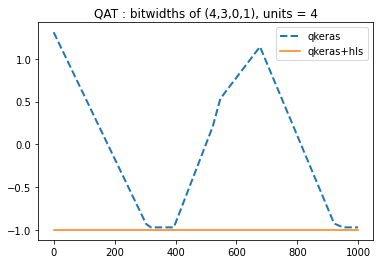

PTQ : bitwidths of (4,3,0,1), units = 6
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<4,4>', 'bias': 'ap_fixed<4,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<4,4>', 'bias': 'ap_fixed<4,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}

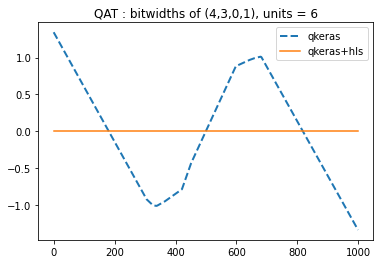

PTQ : bitwidths of (4,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<4,4>', 'bias': 'ap_fixed<4,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<4,4>', 'bias': 'ap_fixed<4,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}

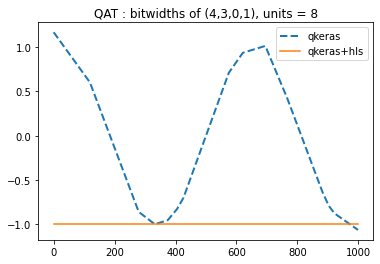

PTQ : bitwidths of (4,3,0,1), units = 10
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<4,4>', 'bias': 'ap_fixed<4,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<4,4>', 'bias': 'ap_fixed<4,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

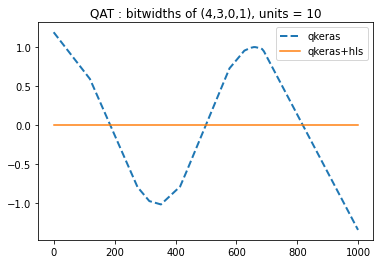

PTQ : bitwidths of (4,3,0,1), units = 12
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<4,4>', 'bias': 'ap_fixed<4,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<4,4>', 'bias': 'ap_fixed<4,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

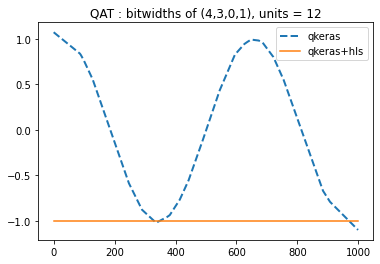

PTQ : bitwidths of (4,3,0,1), units = 14
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<4,4>', 'bias': 'ap_fixed<4,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<4,4>', 'bias': 'ap_fixed<4,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

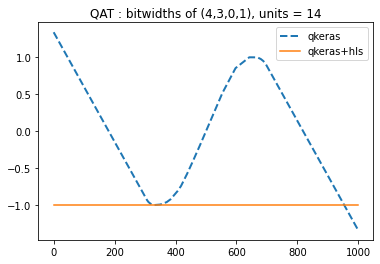

PTQ : bitwidths of (4,3,0,1), units = 16
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<4,4>', 'bias': 'ap_fixed<4,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<4,4>', 'bias': 'ap_fixed<4,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

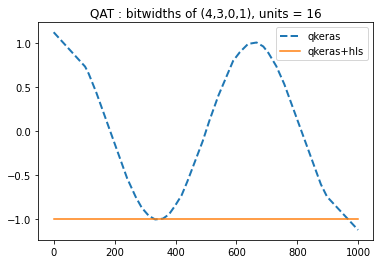

PTQ : bitwidths of (4,3,0,1), units = 18
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<4,4>', 'bias': 'ap_fixed<4,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<4,4>', 'bias': 'ap_fixed<4,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

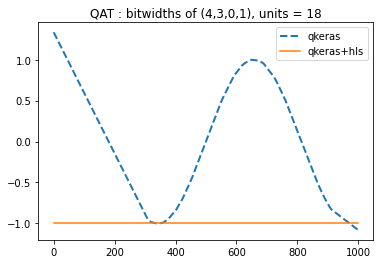

PTQ : bitwidths of (4,3,0,1), units = 20
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<4,4>', 'bias': 'ap_fixed<4,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<4,4>', 'bias': 'ap_fixed<4,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

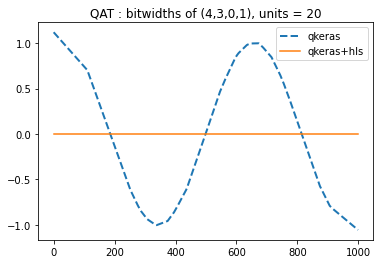

PTQ : bitwidths of (4,3,0,1), units = 22
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<4,4>', 'bias': 'ap_fixed<4,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<4,4>', 'bias': 'ap_fixed<4,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

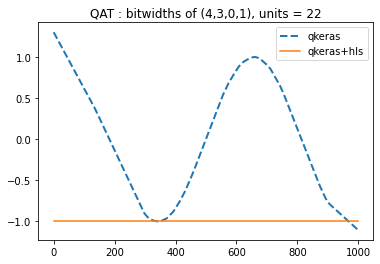

PTQ : bitwidths of (4,3,0,1), units = 24
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<4,4>', 'bias': 'ap_fixed<4,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<4,4>', 'bias': 'ap_fixed<4,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

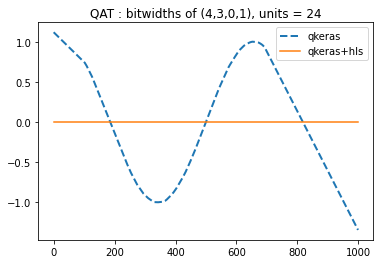

PTQ : bitwidths of (4,3,0,1), units = 26
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<4,4>', 'bias': 'ap_fixed<4,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<4,4>', 'bias': 'ap_fixed<4,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

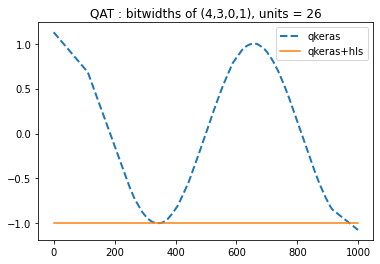

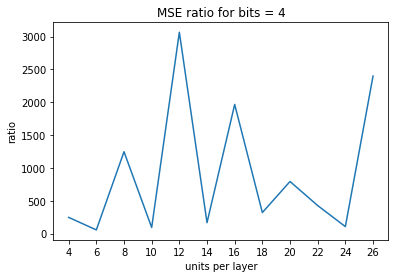

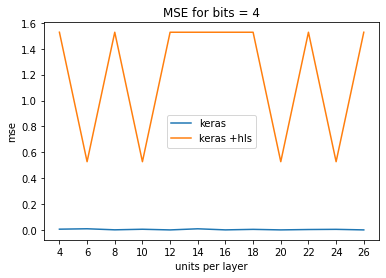

PTQ : bitwidths of (5,3,0,1), units = 4
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}

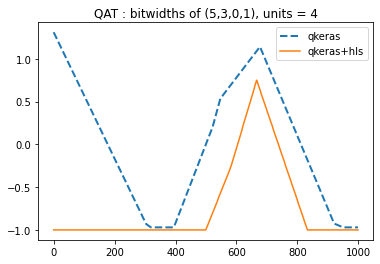

PTQ : bitwidths of (5,3,0,1), units = 6
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}

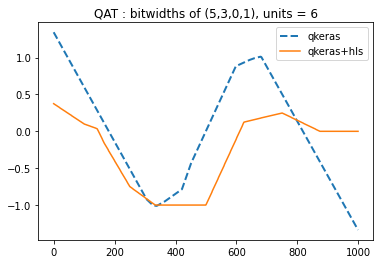

PTQ : bitwidths of (5,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}

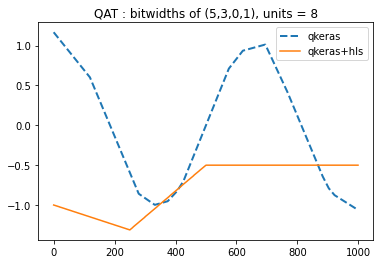

PTQ : bitwidths of (5,3,0,1), units = 10
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

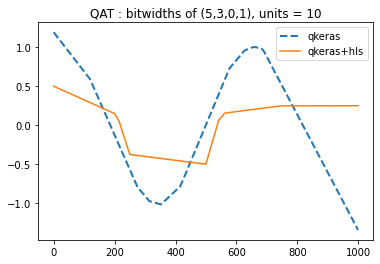

PTQ : bitwidths of (5,3,0,1), units = 12
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

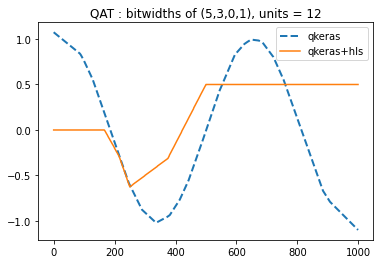

PTQ : bitwidths of (5,3,0,1), units = 14
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

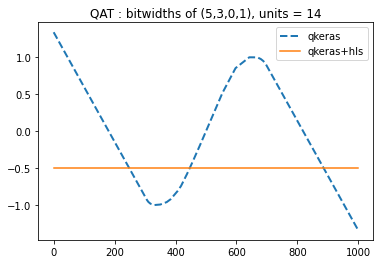

PTQ : bitwidths of (5,3,0,1), units = 16
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

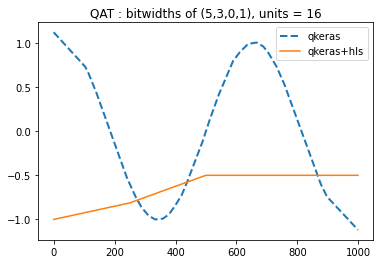

PTQ : bitwidths of (5,3,0,1), units = 18
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

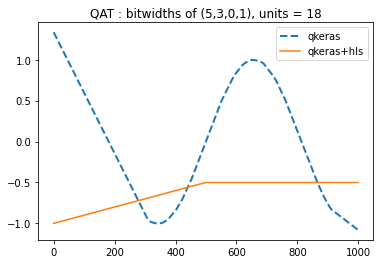

PTQ : bitwidths of (5,3,0,1), units = 20
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

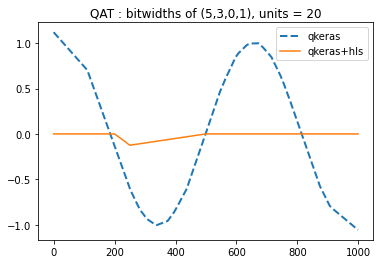

PTQ : bitwidths of (5,3,0,1), units = 22
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

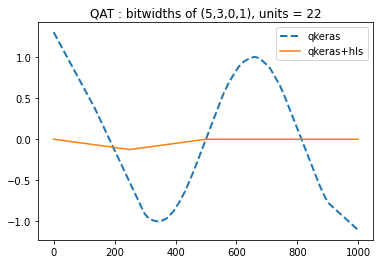

PTQ : bitwidths of (5,3,0,1), units = 24
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

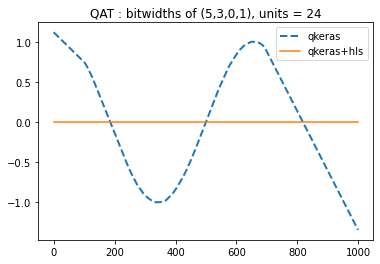

PTQ : bitwidths of (5,3,0,1), units = 26
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

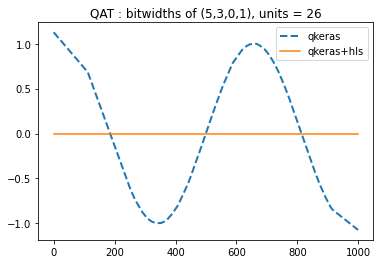

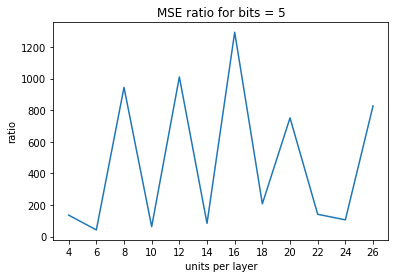

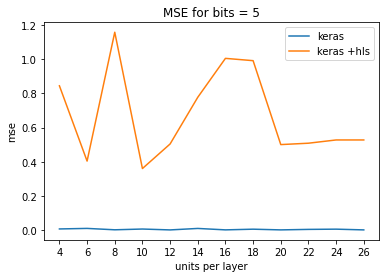

PTQ : bitwidths of (6,3,0,1), units = 4
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}

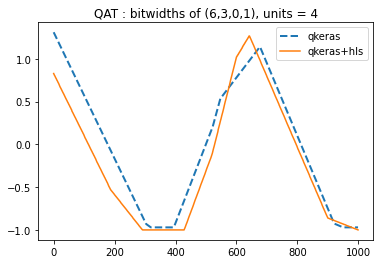

PTQ : bitwidths of (6,3,0,1), units = 6
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}

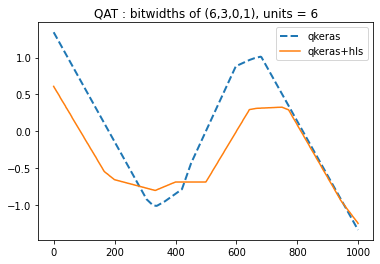

PTQ : bitwidths of (6,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}

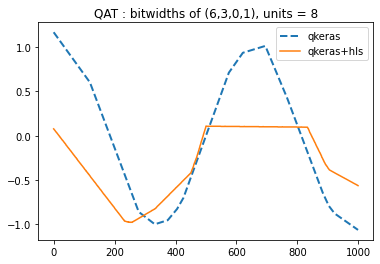

PTQ : bitwidths of (6,3,0,1), units = 10
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

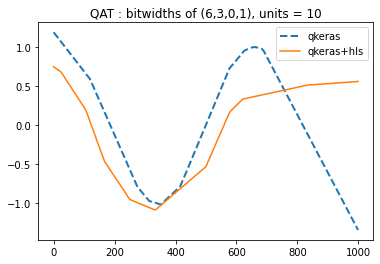

PTQ : bitwidths of (6,3,0,1), units = 12
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

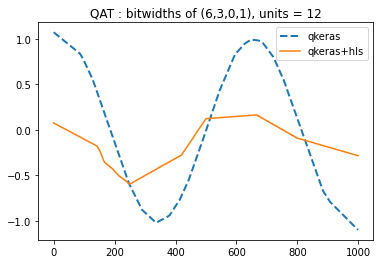

PTQ : bitwidths of (6,3,0,1), units = 14
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

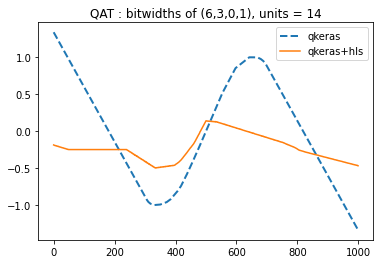

PTQ : bitwidths of (6,3,0,1), units = 16
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

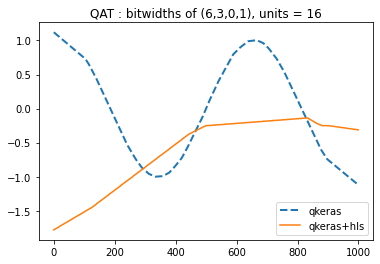

PTQ : bitwidths of (6,3,0,1), units = 18
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

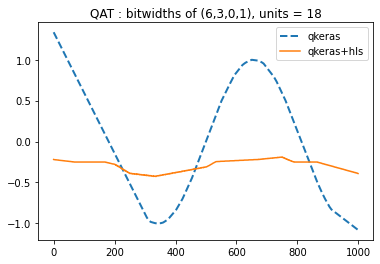

PTQ : bitwidths of (6,3,0,1), units = 20
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

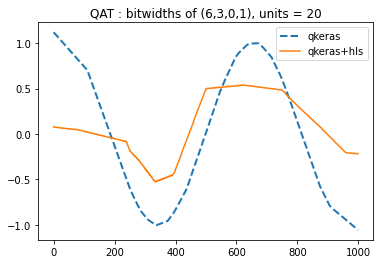

PTQ : bitwidths of (6,3,0,1), units = 22
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

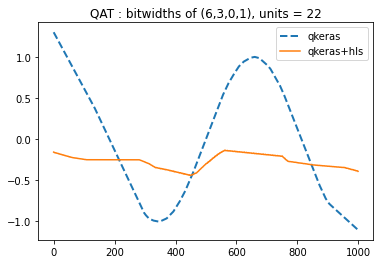

PTQ : bitwidths of (6,3,0,1), units = 24
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

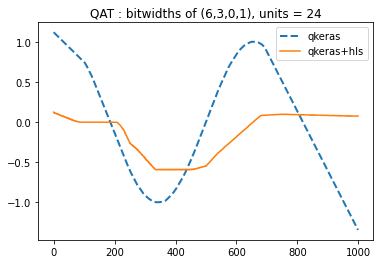

PTQ : bitwidths of (6,3,0,1), units = 26
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

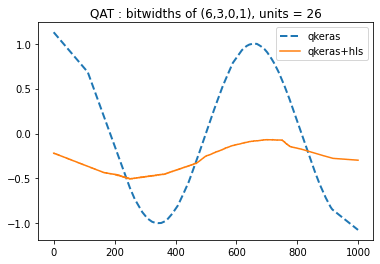

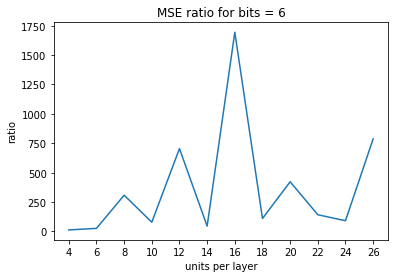

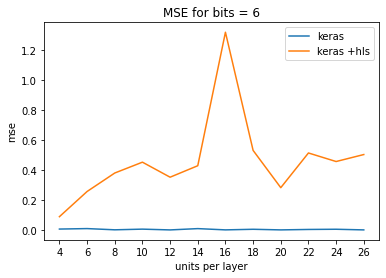

PTQ : bitwidths of (7,3,0,1), units = 4
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}

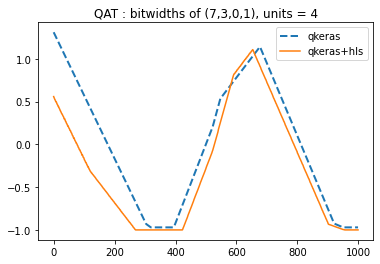

PTQ : bitwidths of (7,3,0,1), units = 6
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}

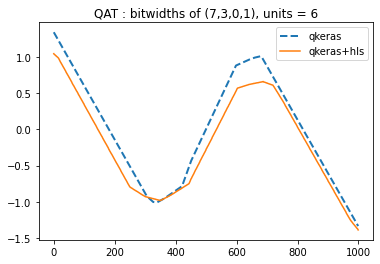

PTQ : bitwidths of (7,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}

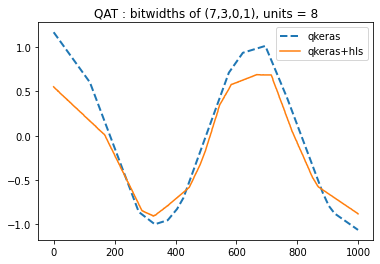

PTQ : bitwidths of (7,3,0,1), units = 10
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

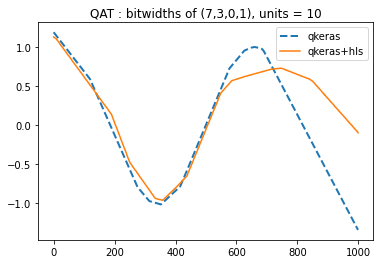

PTQ : bitwidths of (7,3,0,1), units = 12
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

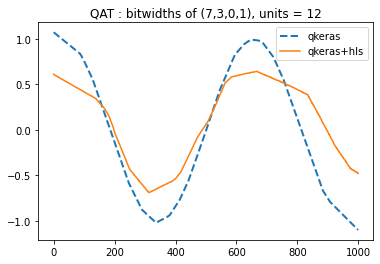

PTQ : bitwidths of (7,3,0,1), units = 14
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

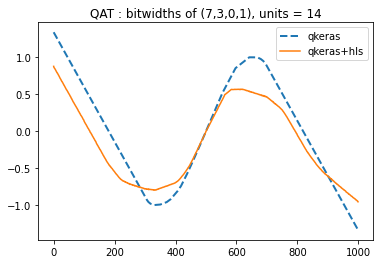

PTQ : bitwidths of (7,3,0,1), units = 16
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

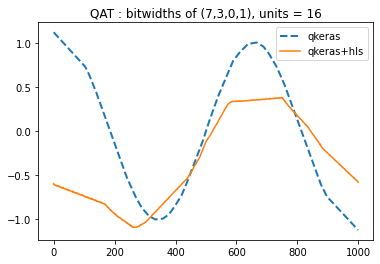

PTQ : bitwidths of (7,3,0,1), units = 18
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

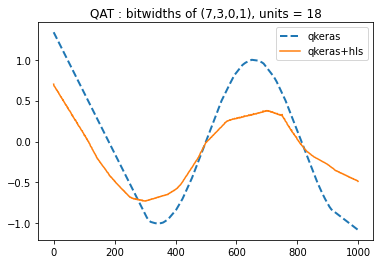

PTQ : bitwidths of (7,3,0,1), units = 20
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

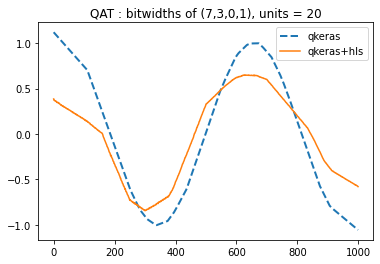

PTQ : bitwidths of (7,3,0,1), units = 22
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

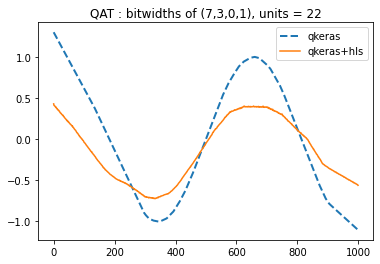

PTQ : bitwidths of (7,3,0,1), units = 24
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

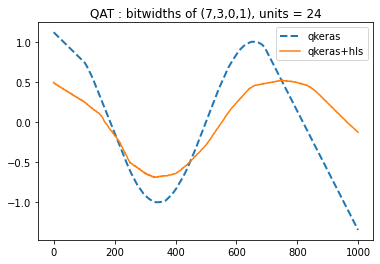

PTQ : bitwidths of (7,3,0,1), units = 26
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

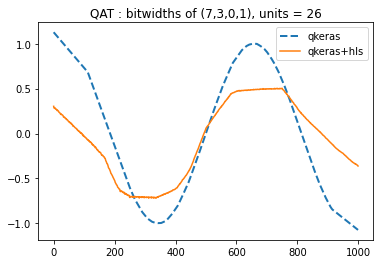

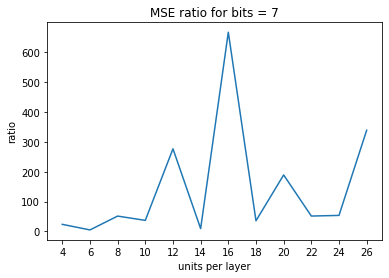

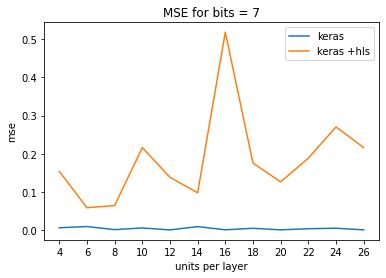

PTQ : bitwidths of (8,3,0,1), units = 4
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}

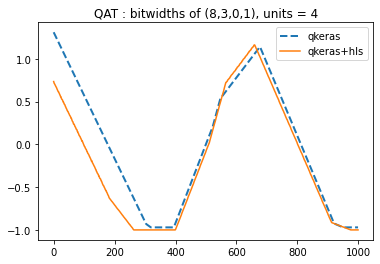

PTQ : bitwidths of (8,3,0,1), units = 6
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}

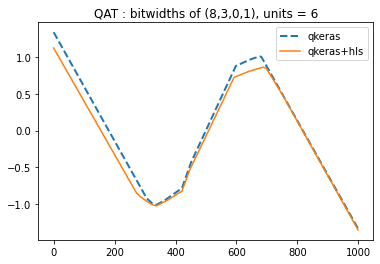

PTQ : bitwidths of (8,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}

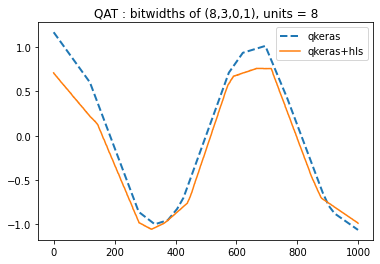

PTQ : bitwidths of (8,3,0,1), units = 10
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

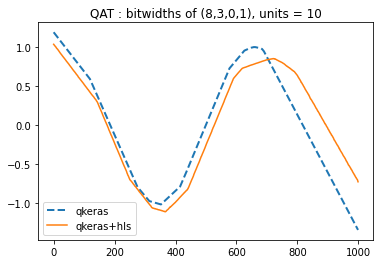

PTQ : bitwidths of (8,3,0,1), units = 12
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

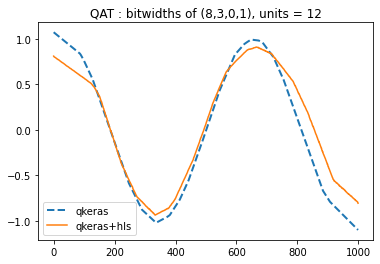

PTQ : bitwidths of (8,3,0,1), units = 14
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

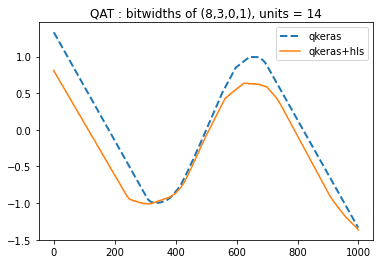

PTQ : bitwidths of (8,3,0,1), units = 16
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

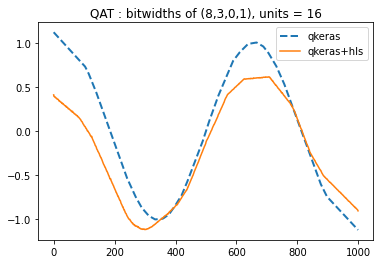

PTQ : bitwidths of (8,3,0,1), units = 18
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

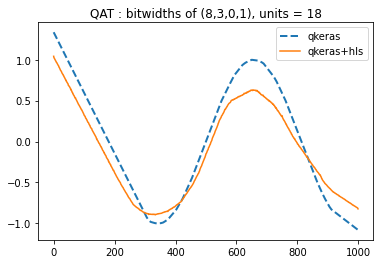

PTQ : bitwidths of (8,3,0,1), units = 20
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

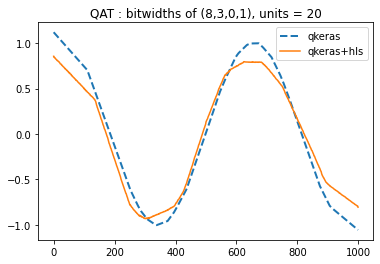

PTQ : bitwidths of (8,3,0,1), units = 22
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

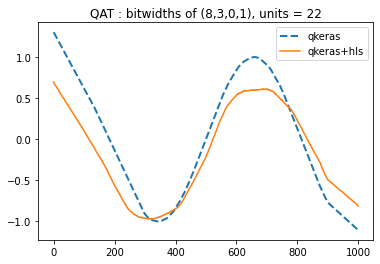

PTQ : bitwidths of (8,3,0,1), units = 24
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

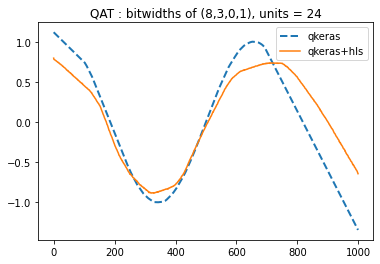

PTQ : bitwidths of (8,3,0,1), units = 26
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

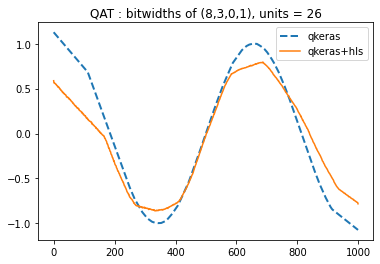

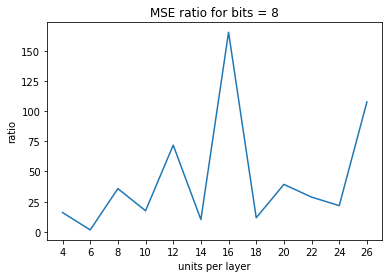

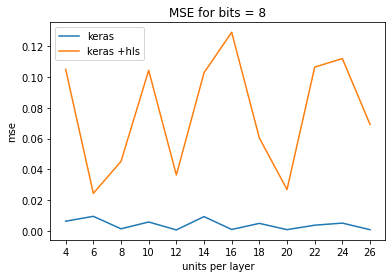

PTQ : bitwidths of (9,3,0,1), units = 4
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}

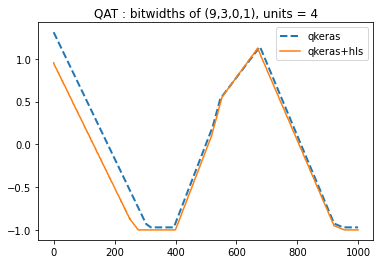

PTQ : bitwidths of (9,3,0,1), units = 6
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}

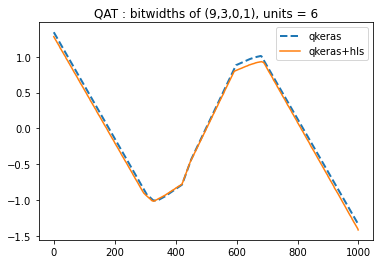

PTQ : bitwidths of (9,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}

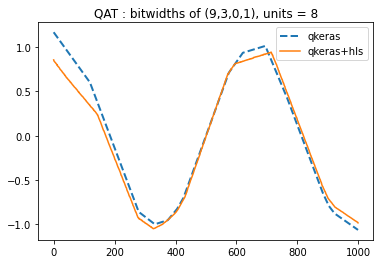

PTQ : bitwidths of (9,3,0,1), units = 10
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

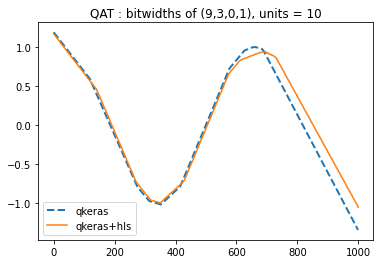

PTQ : bitwidths of (9,3,0,1), units = 12
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

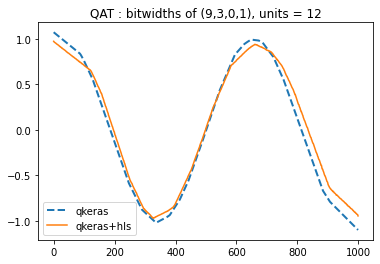

PTQ : bitwidths of (9,3,0,1), units = 14
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

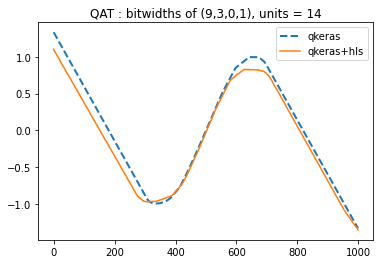

PTQ : bitwidths of (9,3,0,1), units = 16
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

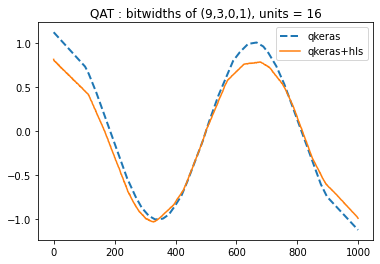

PTQ : bitwidths of (9,3,0,1), units = 18
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

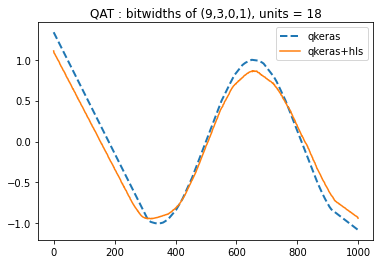

PTQ : bitwidths of (9,3,0,1), units = 20
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

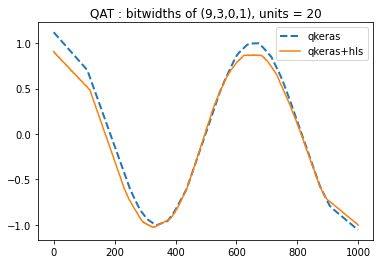

PTQ : bitwidths of (9,3,0,1), units = 22
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

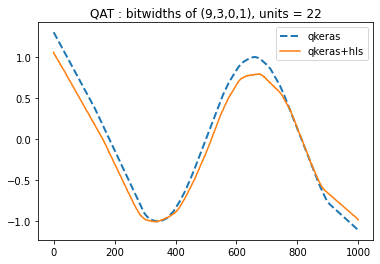

PTQ : bitwidths of (9,3,0,1), units = 24
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

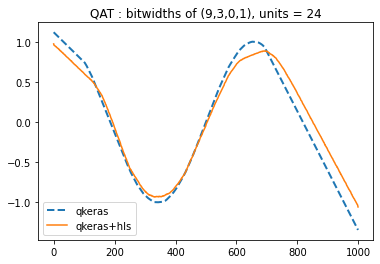

PTQ : bitwidths of (9,3,0,1), units = 26
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

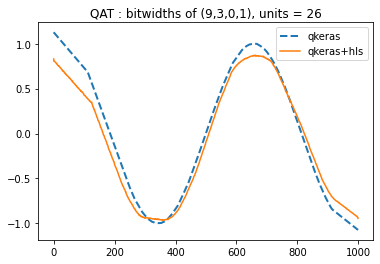

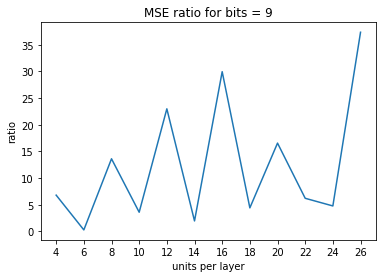

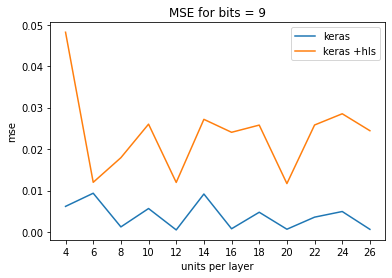

PTQ : bitwidths of (10,3,0,1), units = 4
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18

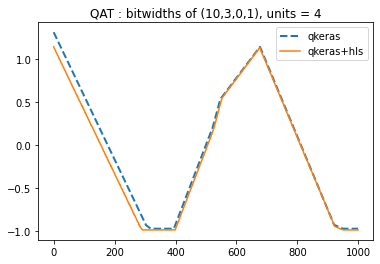

PTQ : bitwidths of (10,3,0,1), units = 6
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18

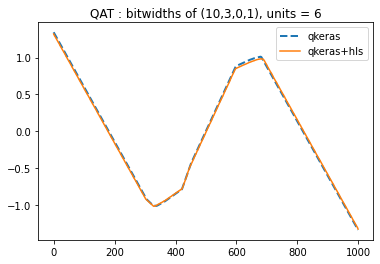

PTQ : bitwidths of (10,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18

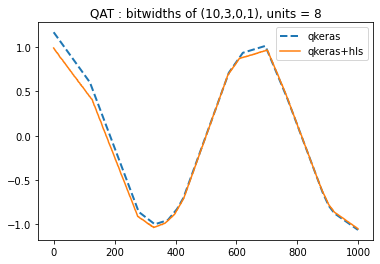

PTQ : bitwidths of (10,3,0,1), units = 10
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

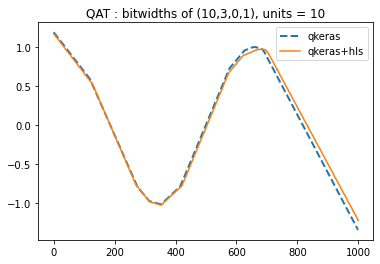

PTQ : bitwidths of (10,3,0,1), units = 12
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

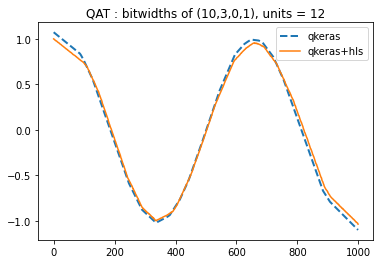

PTQ : bitwidths of (10,3,0,1), units = 14
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

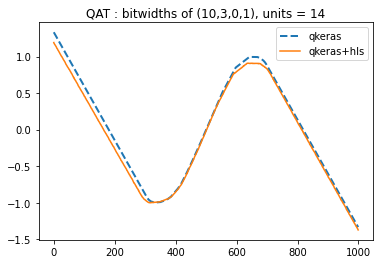

PTQ : bitwidths of (10,3,0,1), units = 16
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

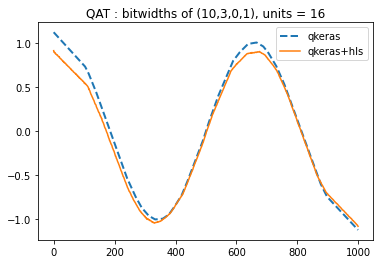

PTQ : bitwidths of (10,3,0,1), units = 18
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

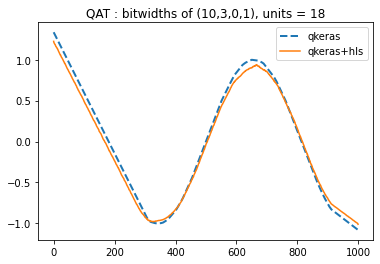

PTQ : bitwidths of (10,3,0,1), units = 20
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

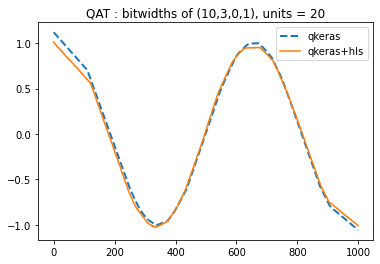

PTQ : bitwidths of (10,3,0,1), units = 22
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

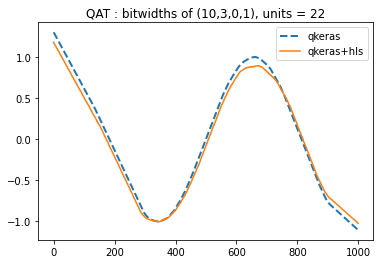

PTQ : bitwidths of (10,3,0,1), units = 24
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

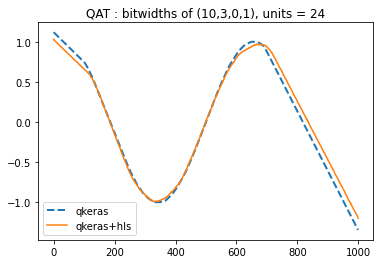

PTQ : bitwidths of (10,3,0,1), units = 26
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

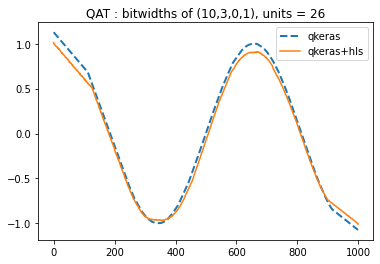

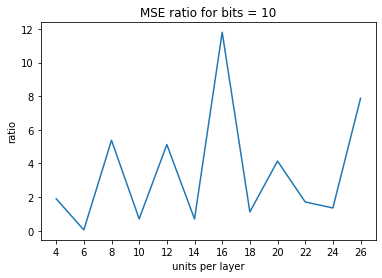

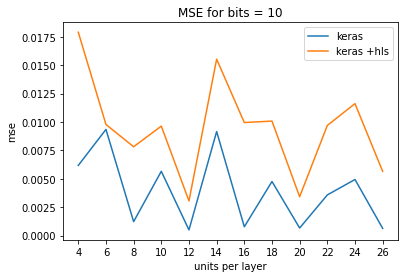

PTQ : bitwidths of (11,3,0,1), units = 4
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18

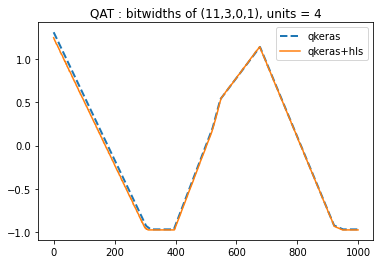

PTQ : bitwidths of (11,3,0,1), units = 6
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18

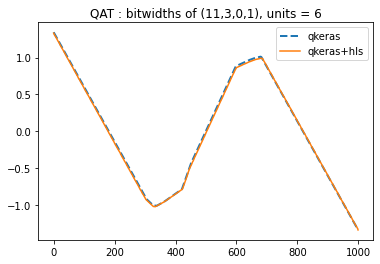

PTQ : bitwidths of (11,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18

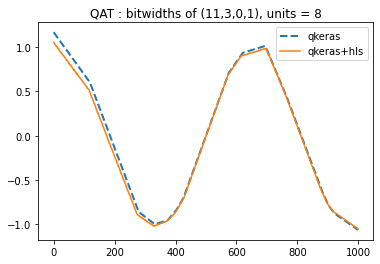

PTQ : bitwidths of (11,3,0,1), units = 10
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

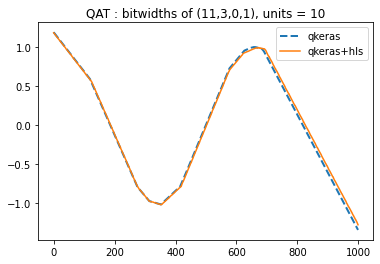

PTQ : bitwidths of (11,3,0,1), units = 12
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

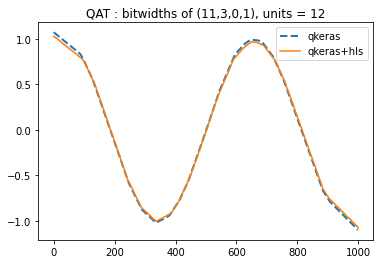

PTQ : bitwidths of (11,3,0,1), units = 14
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

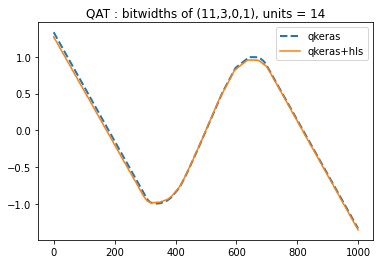

PTQ : bitwidths of (11,3,0,1), units = 16
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

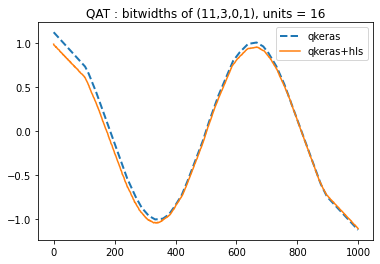

PTQ : bitwidths of (11,3,0,1), units = 18
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

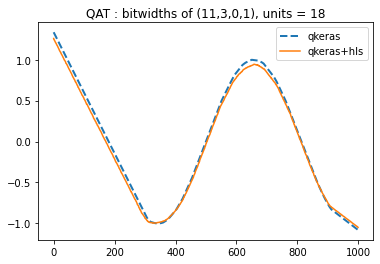

PTQ : bitwidths of (11,3,0,1), units = 20
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

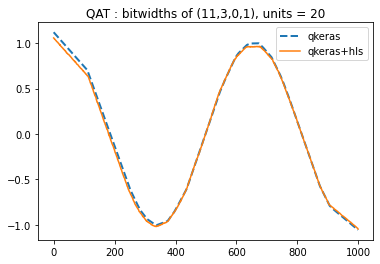

PTQ : bitwidths of (11,3,0,1), units = 22
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

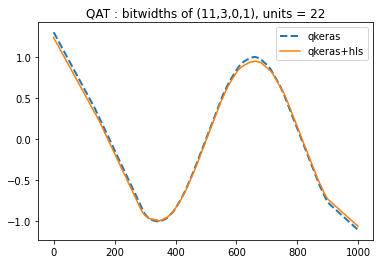

PTQ : bitwidths of (11,3,0,1), units = 24
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

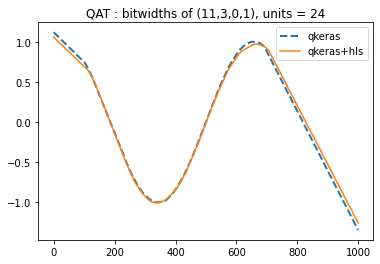

PTQ : bitwidths of (11,3,0,1), units = 26
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

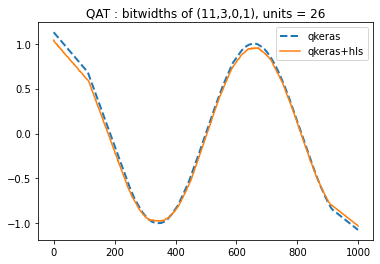

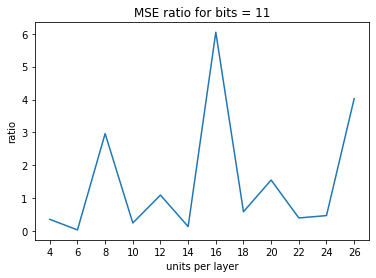

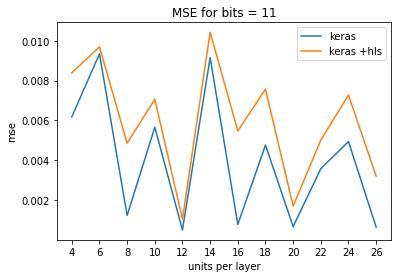

PTQ : bitwidths of (12,3,0,1), units = 4
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18

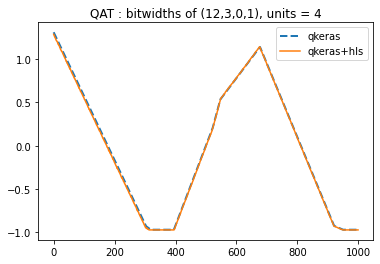

PTQ : bitwidths of (12,3,0,1), units = 6
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18

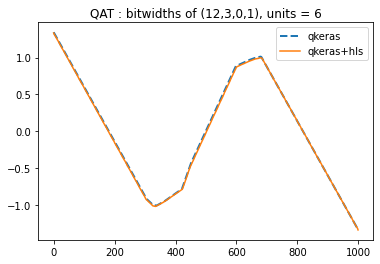

PTQ : bitwidths of (12,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18

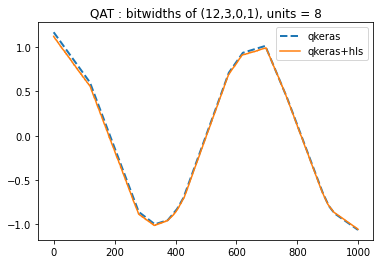

PTQ : bitwidths of (12,3,0,1), units = 10
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

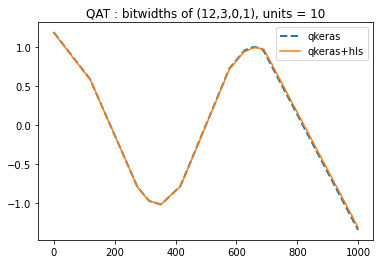

PTQ : bitwidths of (12,3,0,1), units = 12
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

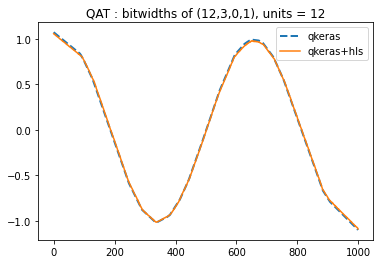

PTQ : bitwidths of (12,3,0,1), units = 14
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

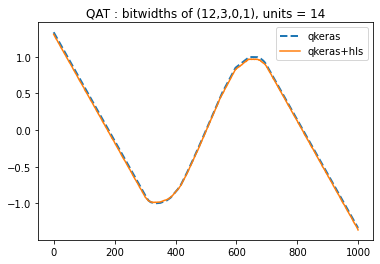

PTQ : bitwidths of (12,3,0,1), units = 16
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

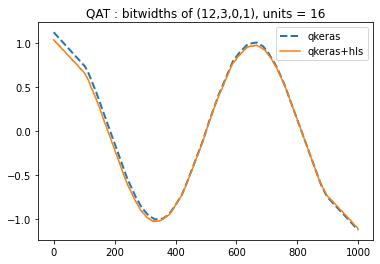

PTQ : bitwidths of (12,3,0,1), units = 18
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

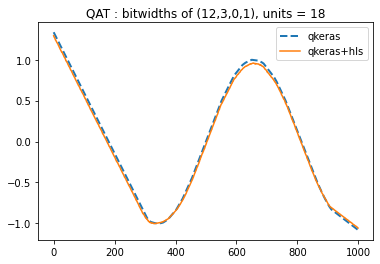

PTQ : bitwidths of (12,3,0,1), units = 20
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

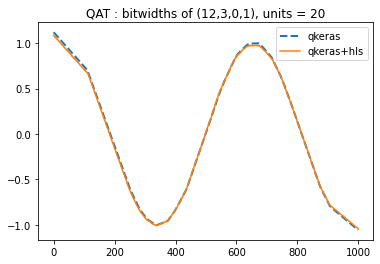

PTQ : bitwidths of (12,3,0,1), units = 22
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

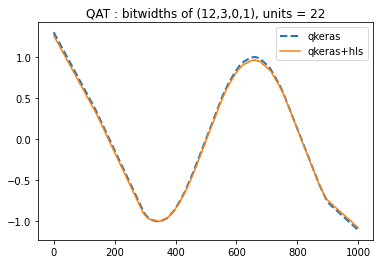

PTQ : bitwidths of (12,3,0,1), units = 24
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

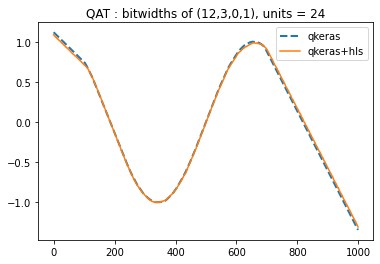

PTQ : bitwidths of (12,3,0,1), units = 26
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

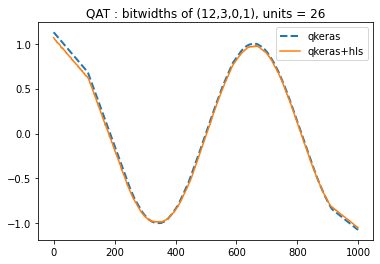

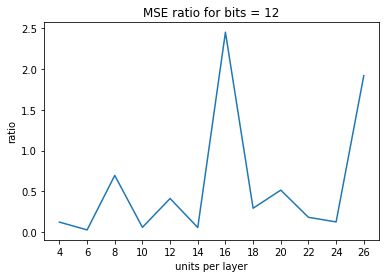

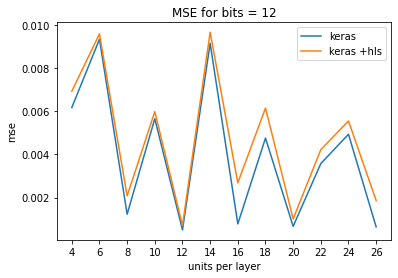

PTQ : bitwidths of (13,3,0,1), units = 4
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18

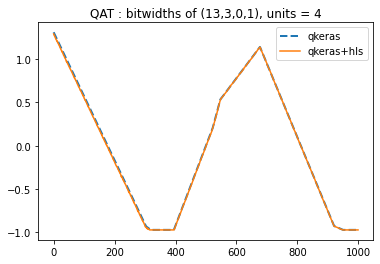

PTQ : bitwidths of (13,3,0,1), units = 6
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18

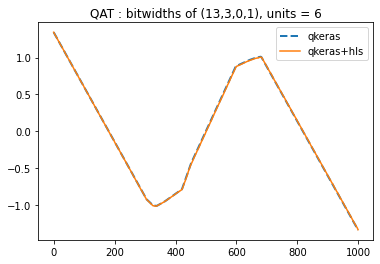

PTQ : bitwidths of (13,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18

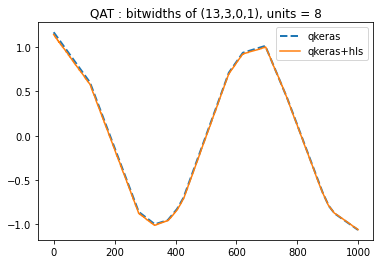

PTQ : bitwidths of (13,3,0,1), units = 10
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

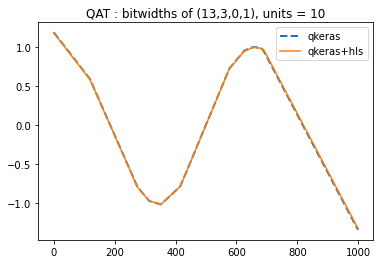

PTQ : bitwidths of (13,3,0,1), units = 12
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

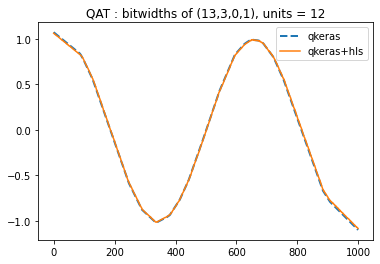

PTQ : bitwidths of (13,3,0,1), units = 14
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

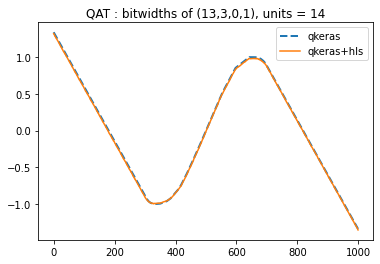

PTQ : bitwidths of (13,3,0,1), units = 16
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

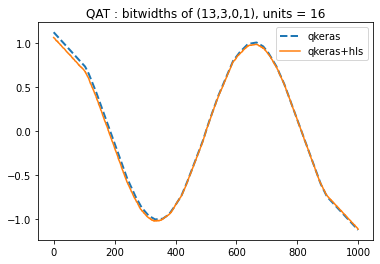

PTQ : bitwidths of (13,3,0,1), units = 18
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

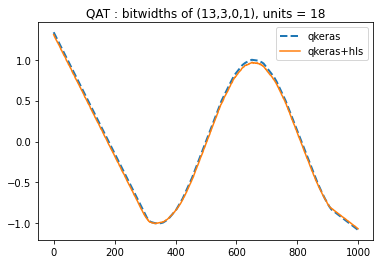

PTQ : bitwidths of (13,3,0,1), units = 20
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

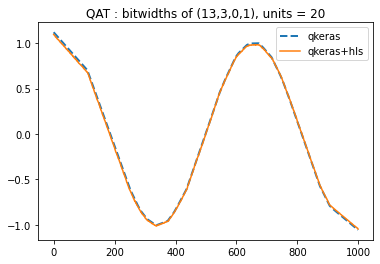

PTQ : bitwidths of (13,3,0,1), units = 22
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

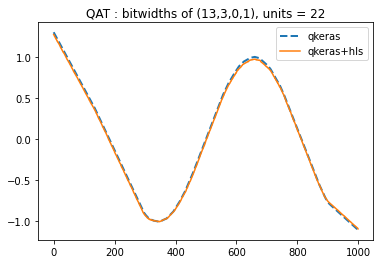

PTQ : bitwidths of (13,3,0,1), units = 24
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

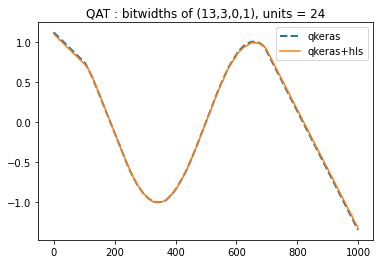

PTQ : bitwidths of (13,3,0,1), units = 26
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

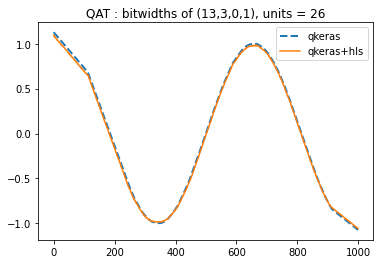

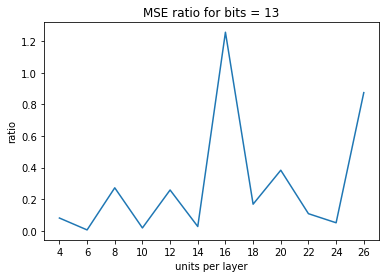

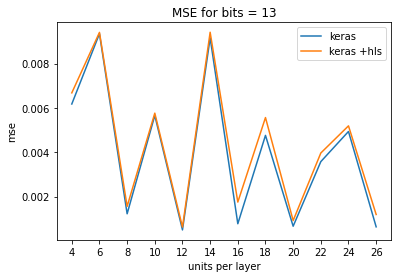

PTQ : bitwidths of (14,3,0,1), units = 4
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18

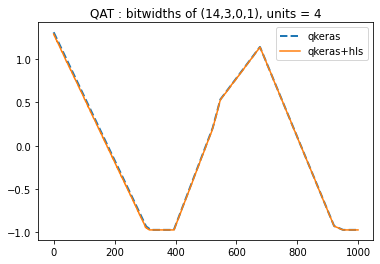

PTQ : bitwidths of (14,3,0,1), units = 6
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18

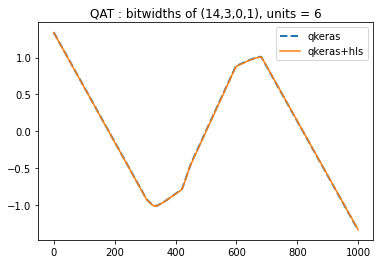

PTQ : bitwidths of (14,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18

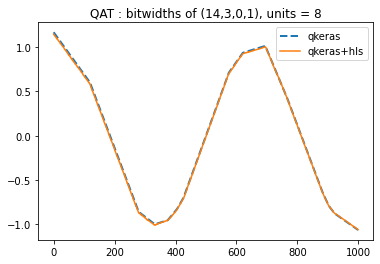

PTQ : bitwidths of (14,3,0,1), units = 10
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

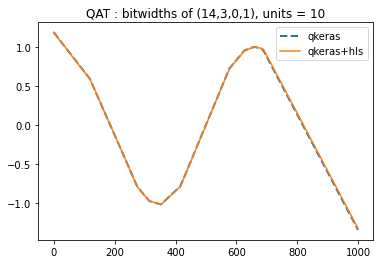

PTQ : bitwidths of (14,3,0,1), units = 12
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

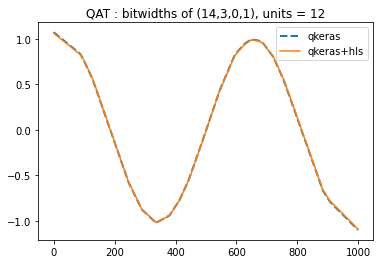

PTQ : bitwidths of (14,3,0,1), units = 14
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

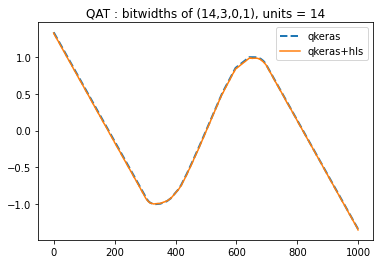

PTQ : bitwidths of (14,3,0,1), units = 16
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

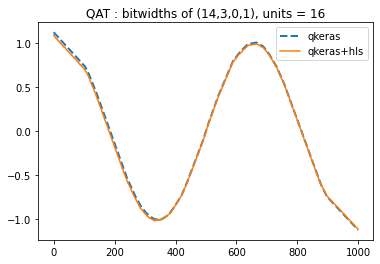

PTQ : bitwidths of (14,3,0,1), units = 18
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

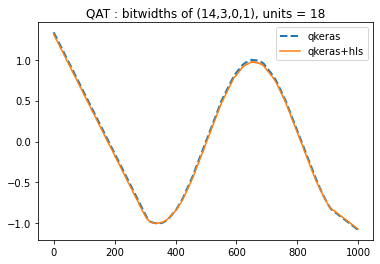

PTQ : bitwidths of (14,3,0,1), units = 20
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

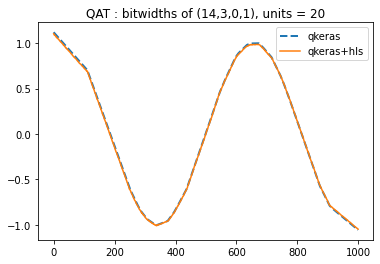

PTQ : bitwidths of (14,3,0,1), units = 22
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

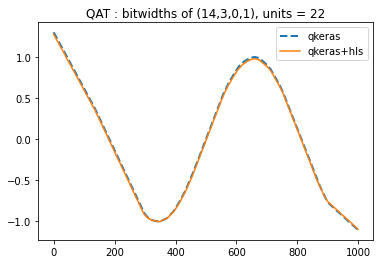

PTQ : bitwidths of (14,3,0,1), units = 24
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

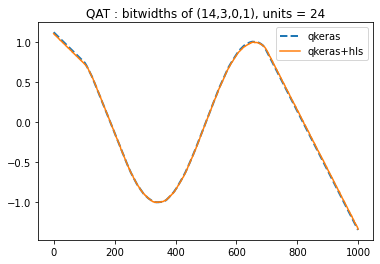

PTQ : bitwidths of (14,3,0,1), units = 26
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

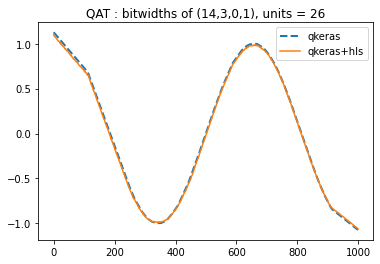

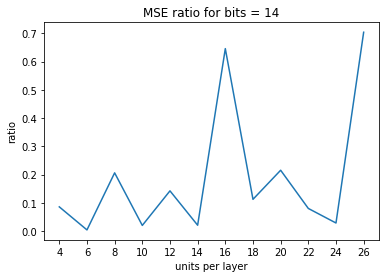

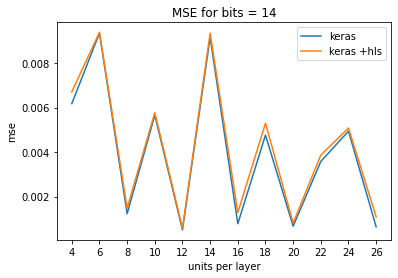

PTQ : bitwidths of (15,3,0,1), units = 4
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18

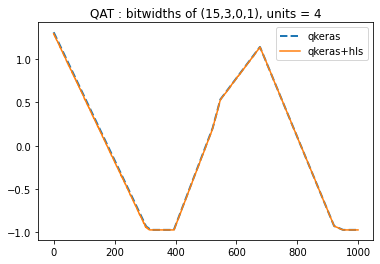

PTQ : bitwidths of (15,3,0,1), units = 6
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18

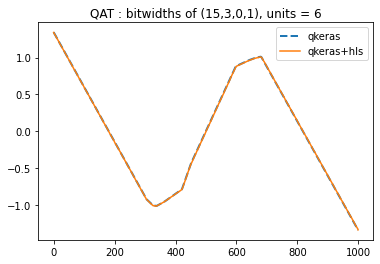

PTQ : bitwidths of (15,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18

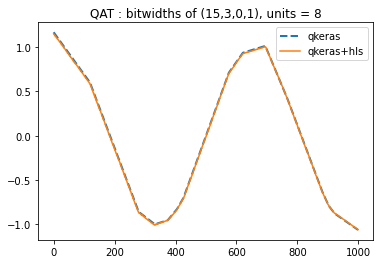

PTQ : bitwidths of (15,3,0,1), units = 10
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

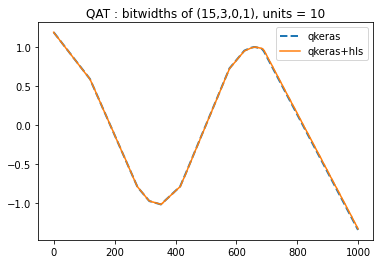

PTQ : bitwidths of (15,3,0,1), units = 12
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

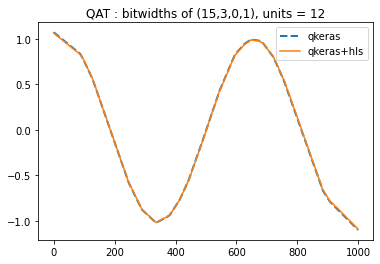

PTQ : bitwidths of (15,3,0,1), units = 14
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

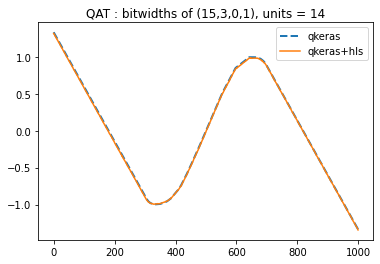

PTQ : bitwidths of (15,3,0,1), units = 16
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

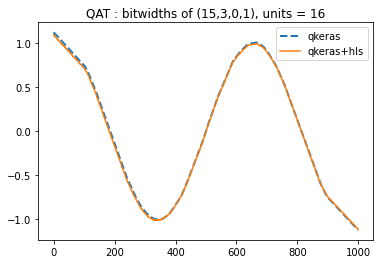

PTQ : bitwidths of (15,3,0,1), units = 18
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

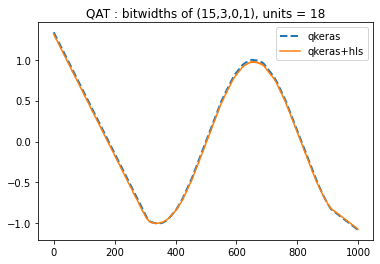

PTQ : bitwidths of (15,3,0,1), units = 20
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

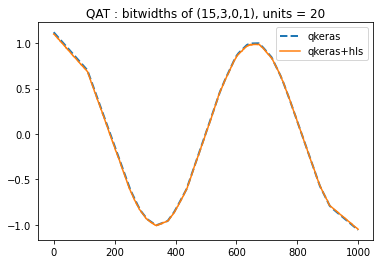

PTQ : bitwidths of (15,3,0,1), units = 22
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

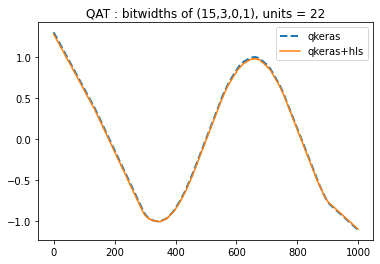

PTQ : bitwidths of (15,3,0,1), units = 24
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

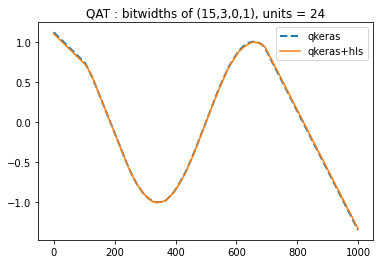

PTQ : bitwidths of (15,3,0,1), units = 26
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<1

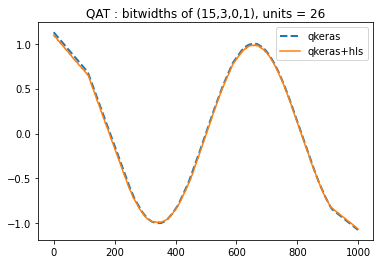

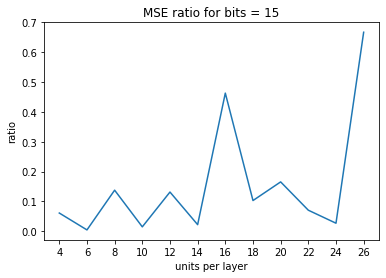

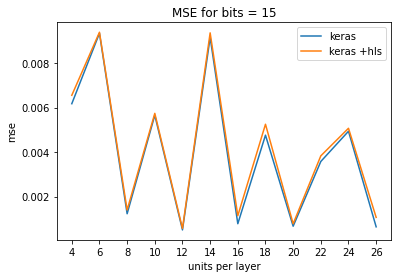

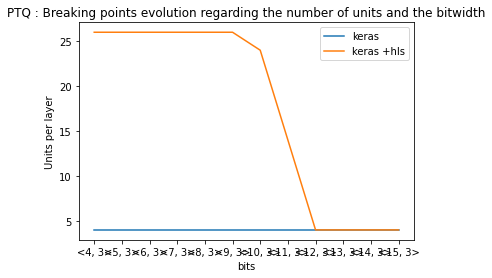

In [9]:
#HLS CONVERSION of the Keras model, every layer

breaking_ratio_points = [] 
bps = []
hls_bps = [] 
bits_nbr = []
ptq_results = []


for i in range (bits_range):
    keras_bp = units(0)
    hls_bp = units(0)
    breaking_ratio_point = units(0)
    units_nbr = []
    mse_ratio = []
    closs = []
    qchloss = []

    for j in range (units_range):
        print(f'PTQ : bitwidths of ({bit_lenghts(i)},{integer},0,1), units = {units(j)}')
        conf = hls4ml.utils.config_from_keras_model(tf.keras.models.load_model(models_path(j)), granularity='name')
        conf['LayerName']['dense']['Precision']['weight'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'
        conf['LayerName']['dense']['Precision']['bias'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'
        #conf['LayerName']['dense']['Precision']['result'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'

        #conf['LayerName']['dense_relu']['Precision'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'
        #conf['LayerName']['dense_relu']['table_t'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'

        conf['LayerName']['dense_1']['Precision']['weight'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'
        conf['LayerName']['dense_1']['Precision']['bias'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'
        #conf['LayerName']['dense_1']['Precision']['result'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'

        #conf['LayerName']['dense_1_relu']['Precision'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'
        #conf['LayerName']['dense_1_relu']['table_t'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'

        conf['LayerName']['dense_2']['Precision']['weight'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'
        conf['LayerName']['dense_2']['Precision']['bias'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'
       # conf['LayerName']['dense_2']['Precision']['result'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'
        
        #conf['LayerName']['dense_2_linear']['Precision'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'
        #conf['LayerName']['dense_2_linear']['table_t'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'
        print(conf)
            
        hls_model = hls4ml.converters.convert_from_keras_model(tf.keras.models.load_model(models_path(j)),
                                                                hls_config=conf,
                                                                output_dir='models/hls_models',
                                                                part='1SG280HU2F50E2VG',
                                                                backend='Quartus')
        hls_model.compile()
        
        y_qchls = exist(qpredicts_path_PTQ(i,j), hls_model)
        ptq_results.append(y_qchls)
        y_keras = existnorm(predicts_path(j), tf.keras.models.load_model(models_path(j)))

        
        units_nbr.append(units(j))
        
        mse_keras = mse(y_test, y_keras)
        mse_qchls = mse(y_test, y_qchls)
        closs.append(mse_keras)
        qchloss.append(mse_qchls)
        
        #Implementation of the breaking point
        ratio =(abs(mse(y_test, y_keras) - mse(y_test, y_qchls))/mse(y_test, y_keras)) #linked the mse of the keras and qhls to see when the two mse are spliting
        print(f'ratio of bits = {bit_lenghts(i)} and units =  {units(j)}',ratio)
        mse_ratio.append(ratio)
        if  (ratio>0.02):
            print('new ratio bp detected')
            breaking_ratio_point = units(j)
        
        if (mse_keras > 0.01):
            print('new bp detected')
            keras_bp = units(j)

        if (mse_qchls > 0.01):
            hls_bp = units(j)

        #Plotting of the predictions
        plt.figure()
        plt.plot(y_keras, '--', linewidth=2)
        plt.plot(y_qchls)    
        plt.legend(['qkeras', 'qkeras+hls'])
        plt.title(f'QAT : bitwidths of ({bit_lenghts(i)},{integer},0,1), units = {units(j)}')
        plt.show()
       

    #plotting of the evolution of the breaking points through the number of units with a given a bit lenghts
    bits_nbr.append(bit_lenghts(i))
    breaking_ratio_points.append(breaking_ratio_point)
    plt.figure()
    plt.plot(mse_ratio)
    plt.xticks(np.arange(len(units_nbr)), [f"{units}" for units in units_nbr])
    plt.xlabel('units per layer')
    plt.ylabel('ratio')
    plt.title(f'MSE ratio for bits = {bit_lenghts(i)}')
    plt.show()

    #plotting the mse for a given bitlenghts
    bps.append(keras_bp)
    hls_bps.append(hls_bp)
    plt.figure()
    plt.plot(closs)
    plt.plot(qchloss)
    plt.xticks(np.arange(len(units_nbr)), [f"{units}" for units in units_nbr])
    plt.legend(['keras','keras +hls'])
    plt.xlabel('units per layer')
    plt.ylabel('mse')
    plt.title(f'MSE for bits = {bit_lenghts(i)}')
    plt.show()


plt.figure()
plt.plot(bps)
plt.plot(hls_bps)
plt.legend(['keras','keras +hls'])
plt.xlabel('bits')
plt.ylabel('Units per layer')
plt.xticks(np.arange(len(bits_nbr)), [f"<{bits}, {integer}>" for bits in bits_nbr])
plt.title('PTQ : Breaking points evolution regarding the number of units and the bitwidth')

plt.show()

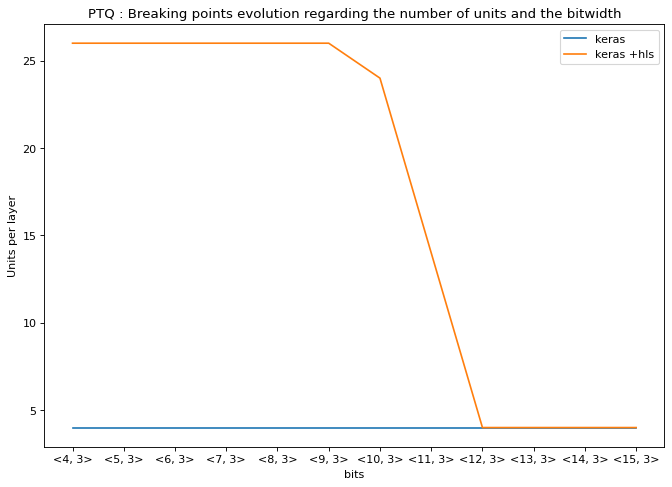

In [10]:
plt.figure(figsize=(10, 7), dpi=80)
plt.plot(bps)
plt.plot(hls_bps)
plt.legend(['keras','keras +hls'])
plt.xlabel('bits')
plt.ylabel('Units per layer')
plt.xticks(np.arange(len(bits_nbr)), [f"<{bits}, {integer}>" for bits in bits_nbr])
plt.title('PTQ : Breaking points evolution regarding the number of units and the bitwidth')

plt.show()

## HLS CONVERSION of the QKeras model

QAT : bitwidths of (4,3,0,1), units = 4
Interpreting Sequential
Topology:
Layer name: q_dense_input, layer type: Input
Layer name: q_dense, layer type: QDense
Layer name: q_dense_1, layer type: QDense
Layer name: q_dense_2, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}, 'q_dense_1': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}, 'q_dense_2': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 4]
Layer name: q_dense_1, layer type: QDense, input shapes: [[None, 4]], output shape: [None, 4]


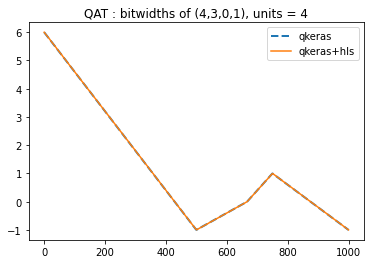

QAT : bitwidths of (4,3,0,1), units = 6
Interpreting Sequential
Topology:
Layer name: q_dense_3_input, layer type: Input
Layer name: q_dense_3, layer type: QDense
Layer name: q_dense_4, layer type: QDense
Layer name: q_dense_5, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_3_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_3': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}, 'q_dense_4': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}, 'q_dense_5': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_3_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_3, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 6]
Layer name: q_dense_4, layer type: QDense, input shapes: [[None, 6]], output shape

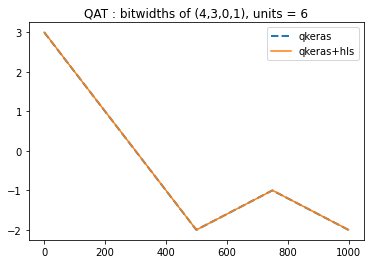

QAT : bitwidths of (4,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: q_dense_6_input, layer type: Input
Layer name: q_dense_6, layer type: QDense
Layer name: q_dense_7, layer type: QDense
Layer name: q_dense_8, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_6_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_6': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}, 'q_dense_7': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}, 'q_dense_8': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_6_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_6, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 8]
Layer name: q_dense_7, layer type: QDense, input shapes: [[None, 8]], output shape

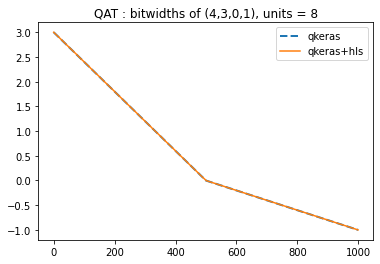

QAT : bitwidths of (4,3,0,1), units = 10
Interpreting Sequential
Topology:
Layer name: q_dense_9_input, layer type: Input
Layer name: q_dense_9, layer type: QDense
Layer name: q_dense_10, layer type: QDense
Layer name: q_dense_11, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_9_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_9': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}, 'q_dense_10': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}, 'q_dense_11': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_9_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_9, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_10, layer type: QDense, input shapes: [[None, 10]], outp

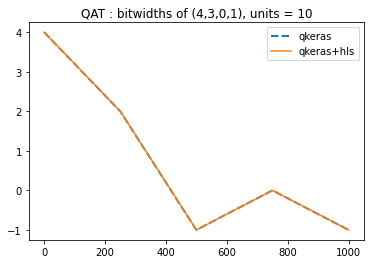

QAT : bitwidths of (4,3,0,1), units = 12
Interpreting Sequential
Topology:
Layer name: q_dense_12_input, layer type: Input
Layer name: q_dense_12, layer type: QDense
Layer name: q_dense_13, layer type: QDense
Layer name: q_dense_14, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_12_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_12': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}, 'q_dense_13': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}, 'q_dense_14': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_12_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_12, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 12]
Layer name: q_dense_13, layer type: QDense, input shapes: [[None, 12]]

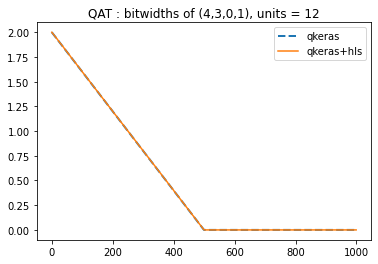

QAT : bitwidths of (4,3,0,1), units = 14
Interpreting Sequential
Topology:
Layer name: q_dense_15_input, layer type: Input
Layer name: q_dense_15, layer type: QDense
Layer name: q_dense_16, layer type: QDense
Layer name: q_dense_17, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_15_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_15': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}, 'q_dense_16': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}, 'q_dense_17': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_15_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_15, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 14]
Layer name: q_dense_16, layer type: QDense, input shapes: [[None, 14]]

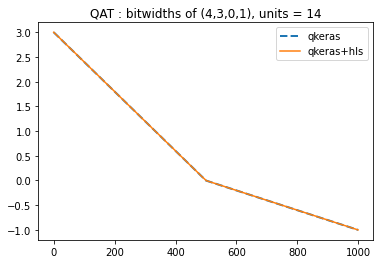

QAT : bitwidths of (4,3,0,1), units = 16
Interpreting Sequential
Topology:
Layer name: q_dense_18_input, layer type: Input
Layer name: q_dense_18, layer type: QDense
Layer name: q_dense_19, layer type: QDense
Layer name: q_dense_20, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_18_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_18': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}, 'q_dense_19': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}, 'q_dense_20': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_18_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_18, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 16]
Layer name: q_dense_19, layer type: QDense, input shapes: [[None, 16]]

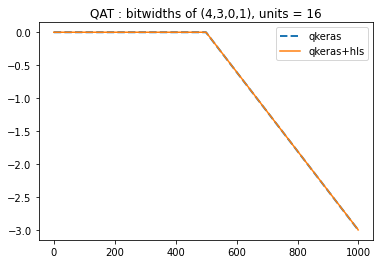

QAT : bitwidths of (4,3,0,1), units = 18
Interpreting Sequential
Topology:
Layer name: q_dense_21_input, layer type: Input
Layer name: q_dense_21, layer type: QDense
Layer name: q_dense_22, layer type: QDense
Layer name: q_dense_23, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_21_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_21': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}, 'q_dense_22': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}, 'q_dense_23': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_21_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_21, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 18]
Layer name: q_dense_22, layer type: QDense, input shapes: [[None, 18]]

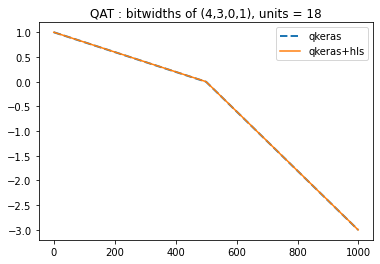

QAT : bitwidths of (4,3,0,1), units = 20
Interpreting Sequential
Topology:
Layer name: q_dense_24_input, layer type: Input
Layer name: q_dense_24, layer type: QDense
Layer name: q_dense_25, layer type: QDense
Layer name: q_dense_26, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_24_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_24': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}, 'q_dense_25': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}, 'q_dense_26': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_24_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_24, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 20]
Layer name: q_dense_25, layer type: QDense, input shapes: [[None, 20]]

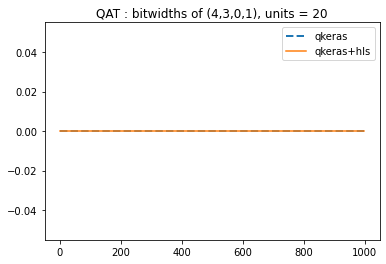

QAT : bitwidths of (4,3,0,1), units = 22
Interpreting Sequential
Topology:
Layer name: q_dense_27_input, layer type: Input
Layer name: q_dense_27, layer type: QDense
Layer name: q_dense_28, layer type: QDense
Layer name: q_dense_29, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_27_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_27': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}, 'q_dense_28': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}, 'q_dense_29': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_27_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_27, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 22]
Layer name: q_dense_28, layer type: QDense, input shapes: [[None, 22]]

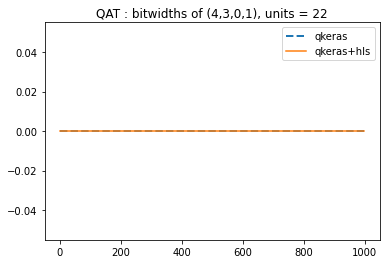

QAT : bitwidths of (4,3,0,1), units = 24
Interpreting Sequential
Topology:
Layer name: q_dense_30_input, layer type: Input
Layer name: q_dense_30, layer type: QDense
Layer name: q_dense_31, layer type: QDense
Layer name: q_dense_32, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_30_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_30': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}, 'q_dense_31': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}, 'q_dense_32': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_30_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_30, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 24]
Layer name: q_dense_31, layer type: QDense, input shapes: [[None, 24]]

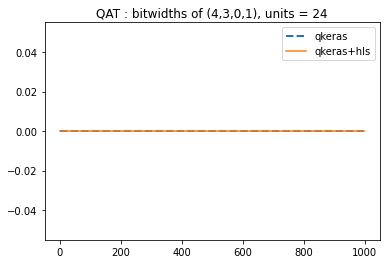

QAT : bitwidths of (4,3,0,1), units = 26
Interpreting Sequential
Topology:
Layer name: q_dense_33_input, layer type: Input
Layer name: q_dense_33, layer type: QDense
Layer name: q_dense_34, layer type: QDense
Layer name: q_dense_35, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_33_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_33': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}, 'q_dense_34': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}, 'q_dense_35': {'Precision': {'weight': 'ap_int<4>', 'bias': 'ap_int<4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_33_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_33, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 26]
Layer name: q_dense_34, layer type: QDense, input shapes: [[None, 26]]

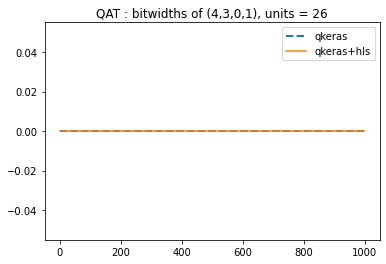

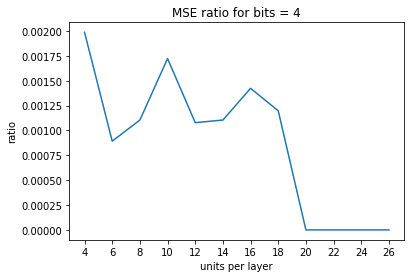

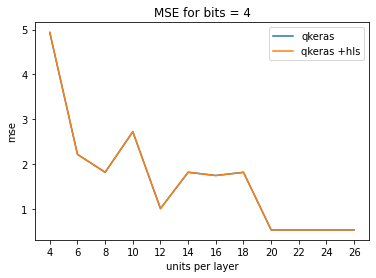

QAT : bitwidths of (5,3,0,1), units = 4
Interpreting Sequential
Topology:
Layer name: q_dense_36_input, layer type: Input
Layer name: q_dense_36, layer type: QDense
Layer name: q_dense_37, layer type: QDense
Layer name: q_dense_38, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_36_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_36': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}, 'q_dense_37': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}, 'q_dense_38': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_36_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_36, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 4]
Layer name: q_dense_37, layer type: QDense, inpu

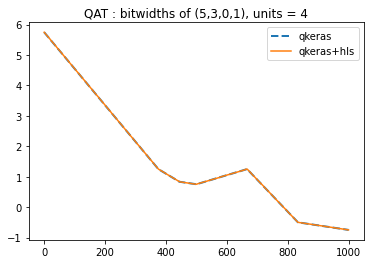

QAT : bitwidths of (5,3,0,1), units = 6
Interpreting Sequential
Topology:
Layer name: q_dense_39_input, layer type: Input
Layer name: q_dense_39, layer type: QDense
Layer name: q_dense_40, layer type: QDense
Layer name: q_dense_41, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_39_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_39': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}, 'q_dense_40': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}, 'q_dense_41': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_39_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_39, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 6]
Layer name: q_dense_40, layer type: QDense, inpu

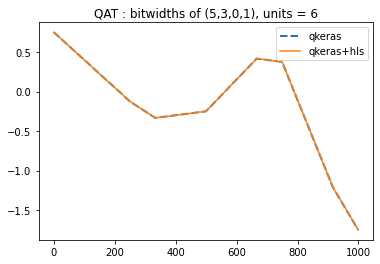

QAT : bitwidths of (5,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: q_dense_42_input, layer type: Input
Layer name: q_dense_42, layer type: QDense
Layer name: q_dense_43, layer type: QDense
Layer name: q_dense_44, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_42_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_42': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}, 'q_dense_43': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}, 'q_dense_44': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_42_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_42, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 8]
Layer name: q_dense_43, layer type: QDense, inpu

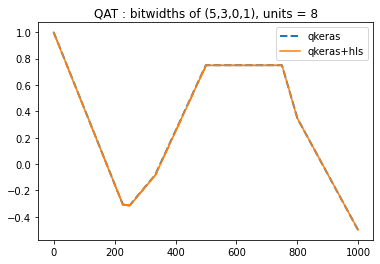

QAT : bitwidths of (5,3,0,1), units = 10
Interpreting Sequential
Topology:
Layer name: q_dense_45_input, layer type: Input
Layer name: q_dense_45, layer type: QDense
Layer name: q_dense_46, layer type: QDense
Layer name: q_dense_47, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_45_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_45': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}, 'q_dense_46': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}, 'q_dense_47': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_45_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_45, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_46, layer type: QDense, in

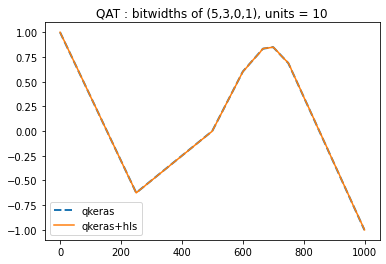

QAT : bitwidths of (5,3,0,1), units = 12
Interpreting Sequential
Topology:
Layer name: q_dense_48_input, layer type: Input
Layer name: q_dense_48, layer type: QDense
Layer name: q_dense_49, layer type: QDense
Layer name: q_dense_50, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_48_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_48': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}, 'q_dense_49': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}, 'q_dense_50': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_48_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_48, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 12]
Layer name: q_dense_49, layer type: QDense, in

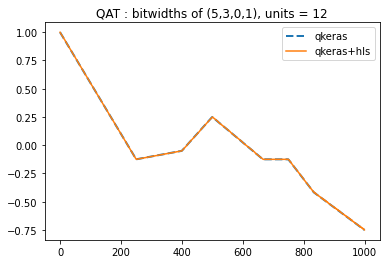

QAT : bitwidths of (5,3,0,1), units = 14
Interpreting Sequential
Topology:
Layer name: q_dense_51_input, layer type: Input
Layer name: q_dense_51, layer type: QDense
Layer name: q_dense_52, layer type: QDense
Layer name: q_dense_53, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_51_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_51': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}, 'q_dense_52': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}, 'q_dense_53': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_51_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_51, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 14]
Layer name: q_dense_52, layer type: QDense, in

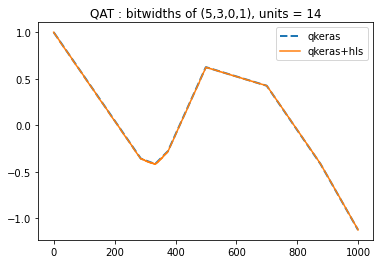

QAT : bitwidths of (5,3,0,1), units = 16
Interpreting Sequential
Topology:
Layer name: q_dense_54_input, layer type: Input
Layer name: q_dense_54, layer type: QDense
Layer name: q_dense_55, layer type: QDense
Layer name: q_dense_56, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_54_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_54': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}, 'q_dense_55': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}, 'q_dense_56': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_54_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_54, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 16]
Layer name: q_dense_55, layer type: QDense, in

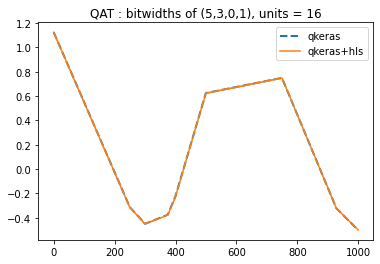

QAT : bitwidths of (5,3,0,1), units = 18
Interpreting Sequential
Topology:
Layer name: q_dense_57_input, layer type: Input
Layer name: q_dense_57, layer type: QDense
Layer name: q_dense_58, layer type: QDense
Layer name: q_dense_59, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_57_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_57': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}, 'q_dense_58': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}, 'q_dense_59': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_57_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_57, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 18]
Layer name: q_dense_58, layer type: QDense, in

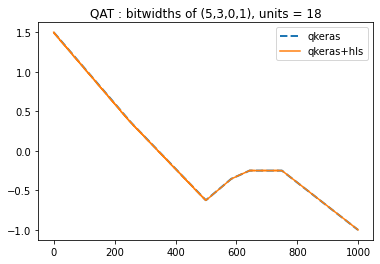

QAT : bitwidths of (5,3,0,1), units = 20
Interpreting Sequential
Topology:
Layer name: q_dense_60_input, layer type: Input
Layer name: q_dense_60, layer type: QDense
Layer name: q_dense_61, layer type: QDense
Layer name: q_dense_62, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_60_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_60': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}, 'q_dense_61': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}, 'q_dense_62': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_60_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_60, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 20]
Layer name: q_dense_61, layer type: QDense, in

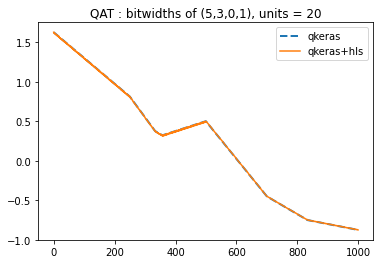

QAT : bitwidths of (5,3,0,1), units = 22
Interpreting Sequential
Topology:
Layer name: q_dense_63_input, layer type: Input
Layer name: q_dense_63, layer type: QDense
Layer name: q_dense_64, layer type: QDense
Layer name: q_dense_65, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_63_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_63': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}, 'q_dense_64': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}, 'q_dense_65': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_63_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_63, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 22]
Layer name: q_dense_64, layer type: QDense, in

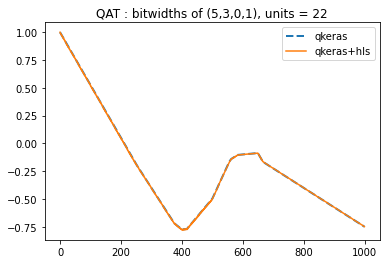

QAT : bitwidths of (5,3,0,1), units = 24
Interpreting Sequential
Topology:
Layer name: q_dense_66_input, layer type: Input
Layer name: q_dense_66, layer type: QDense
Layer name: q_dense_67, layer type: QDense
Layer name: q_dense_68, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_66_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_66': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}, 'q_dense_67': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}, 'q_dense_68': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_66_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_66, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 24]
Layer name: q_dense_67, layer type: QDense, in

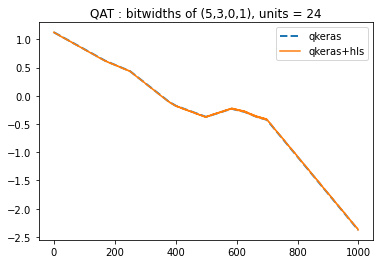

QAT : bitwidths of (5,3,0,1), units = 26
Interpreting Sequential
Topology:
Layer name: q_dense_69_input, layer type: Input
Layer name: q_dense_69, layer type: QDense
Layer name: q_dense_70, layer type: QDense
Layer name: q_dense_71, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_69_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_69': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}, 'q_dense_70': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}, 'q_dense_71': {'Precision': {'weight': 'ap_fixed<5,4>', 'bias': 'ap_fixed<5,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_69_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_69, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 26]
Layer name: q_dense_70, layer type: QDense, in

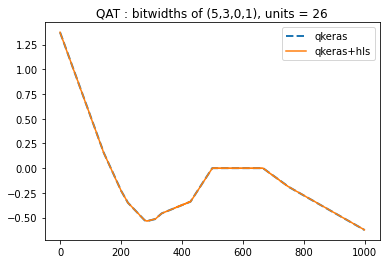

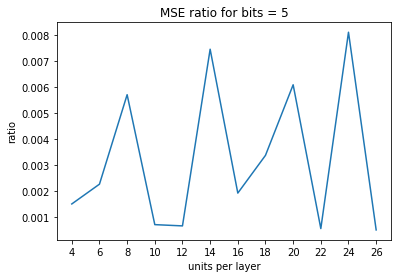

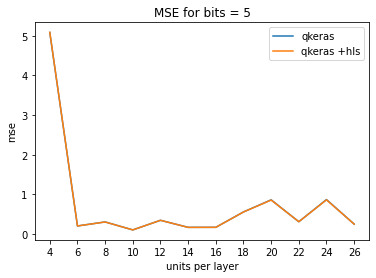

QAT : bitwidths of (6,3,0,1), units = 4
Interpreting Sequential
Topology:
Layer name: q_dense_72_input, layer type: Input
Layer name: q_dense_72, layer type: QDense
Layer name: q_dense_73, layer type: QDense
Layer name: q_dense_74, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_72_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_72': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_73': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_74': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_72_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_72, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 4]
Layer name: q_dense_73, layer type: QDense, inpu

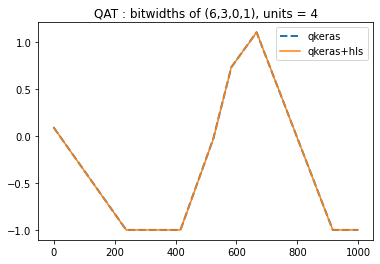

QAT : bitwidths of (6,3,0,1), units = 6
Interpreting Sequential
Topology:
Layer name: q_dense_75_input, layer type: Input
Layer name: q_dense_75, layer type: QDense
Layer name: q_dense_76, layer type: QDense
Layer name: q_dense_77, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_75_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_75': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_76': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_77': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_75_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_75, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 6]
Layer name: q_dense_76, layer type: QDense, inpu

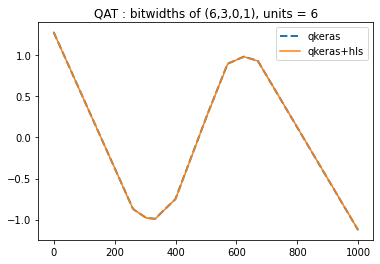

QAT : bitwidths of (6,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: q_dense_78_input, layer type: Input
Layer name: q_dense_78, layer type: QDense
Layer name: q_dense_79, layer type: QDense
Layer name: q_dense_80, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_78_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_78': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_79': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_80': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_78_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_78, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 8]
Layer name: q_dense_79, layer type: QDense, inpu

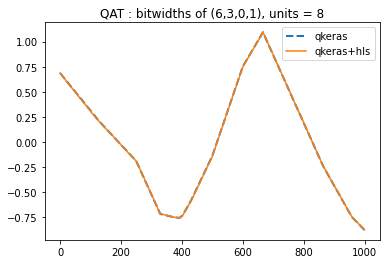

QAT : bitwidths of (6,3,0,1), units = 10
Interpreting Sequential
Topology:
Layer name: q_dense_81_input, layer type: Input
Layer name: q_dense_81, layer type: QDense
Layer name: q_dense_82, layer type: QDense
Layer name: q_dense_83, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_81_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_81': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_82': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_83': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_81_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_81, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_82, layer type: QDense, in

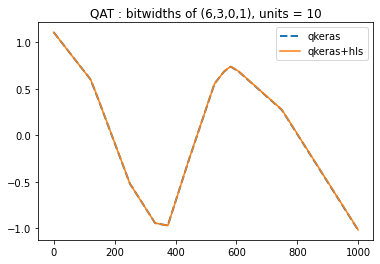

QAT : bitwidths of (6,3,0,1), units = 12
Interpreting Sequential
Topology:
Layer name: q_dense_84_input, layer type: Input
Layer name: q_dense_84, layer type: QDense
Layer name: q_dense_85, layer type: QDense
Layer name: q_dense_86, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_84_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_84': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_85': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_86': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_84_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_84, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 12]
Layer name: q_dense_85, layer type: QDense, in

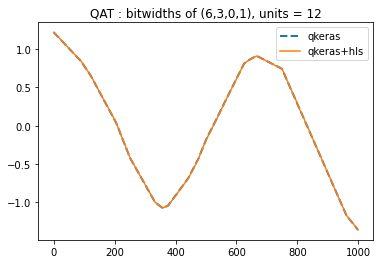

QAT : bitwidths of (6,3,0,1), units = 14
Interpreting Sequential
Topology:
Layer name: q_dense_87_input, layer type: Input
Layer name: q_dense_87, layer type: QDense
Layer name: q_dense_88, layer type: QDense
Layer name: q_dense_89, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_87_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_87': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_88': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_89': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_87_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_87, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 14]
Layer name: q_dense_88, layer type: QDense, in

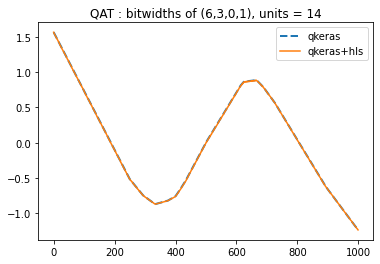

QAT : bitwidths of (6,3,0,1), units = 16
Interpreting Sequential
Topology:
Layer name: q_dense_90_input, layer type: Input
Layer name: q_dense_90, layer type: QDense
Layer name: q_dense_91, layer type: QDense
Layer name: q_dense_92, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_90_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_90': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_91': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_92': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_90_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_90, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 16]
Layer name: q_dense_91, layer type: QDense, in

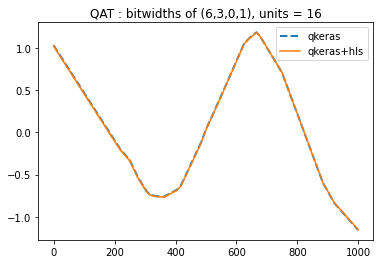

QAT : bitwidths of (6,3,0,1), units = 18
Interpreting Sequential
Topology:
Layer name: q_dense_93_input, layer type: Input
Layer name: q_dense_93, layer type: QDense
Layer name: q_dense_94, layer type: QDense
Layer name: q_dense_95, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_93_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_93': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_94': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_95': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_93_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_93, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 18]
Layer name: q_dense_94, layer type: QDense, in

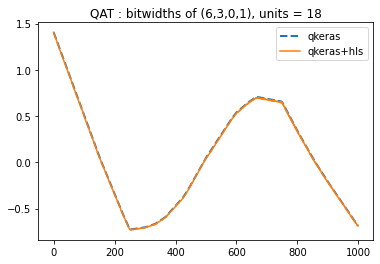

QAT : bitwidths of (6,3,0,1), units = 20
Interpreting Sequential
Topology:
Layer name: q_dense_96_input, layer type: Input
Layer name: q_dense_96, layer type: QDense
Layer name: q_dense_97, layer type: QDense
Layer name: q_dense_98, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_96_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_96': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_97': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_98': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_96_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_96, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 20]
Layer name: q_dense_97, layer type: QDense, in

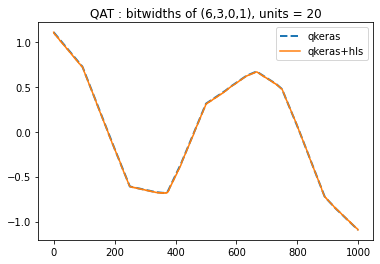

QAT : bitwidths of (6,3,0,1), units = 22
Interpreting Sequential
Topology:
Layer name: q_dense_99_input, layer type: Input
Layer name: q_dense_99, layer type: QDense
Layer name: q_dense_100, layer type: QDense
Layer name: q_dense_101, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_99_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_99': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_100': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_101': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_99_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_99, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 22]
Layer name: q_dense_100, layer type: QDens

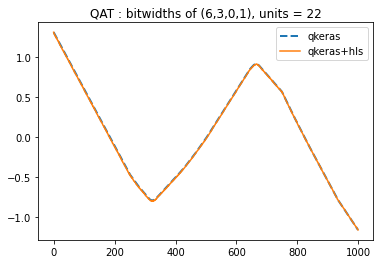

QAT : bitwidths of (6,3,0,1), units = 24
Interpreting Sequential
Topology:
Layer name: q_dense_102_input, layer type: Input
Layer name: q_dense_102, layer type: QDense
Layer name: q_dense_103, layer type: QDense
Layer name: q_dense_104, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_102_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_102': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_103': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_104': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_102_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_102, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 24]
Layer name: q_dense_103, layer type:

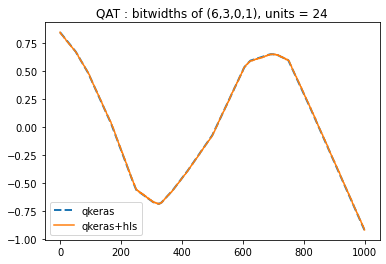

QAT : bitwidths of (6,3,0,1), units = 26
Interpreting Sequential
Topology:
Layer name: q_dense_105_input, layer type: Input
Layer name: q_dense_105, layer type: QDense
Layer name: q_dense_106, layer type: QDense
Layer name: q_dense_107, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_105_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_105': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_106': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_107': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_105_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_105, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 26]
Layer name: q_dense_106, layer type:

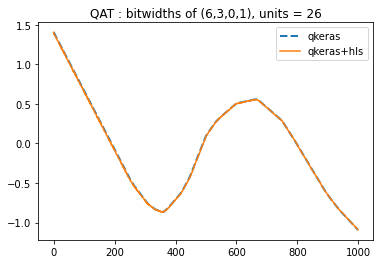

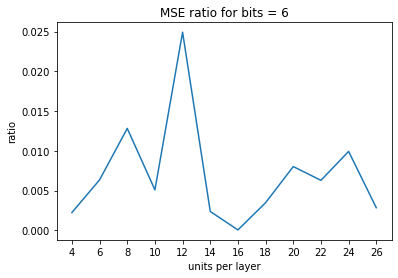

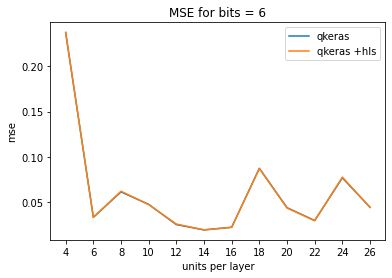

QAT : bitwidths of (7,3,0,1), units = 4
Interpreting Sequential
Topology:
Layer name: q_dense_108_input, layer type: Input
Layer name: q_dense_108, layer type: QDense
Layer name: q_dense_109, layer type: QDense
Layer name: q_dense_110, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_108_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_108': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}, 'q_dense_109': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}, 'q_dense_110': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_108_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_108, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 4]
Layer name: q_dense_109, layer type: Q

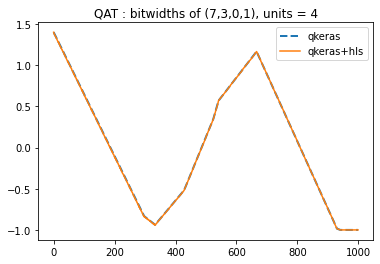

QAT : bitwidths of (7,3,0,1), units = 6
Interpreting Sequential
Topology:
Layer name: q_dense_111_input, layer type: Input
Layer name: q_dense_111, layer type: QDense
Layer name: q_dense_112, layer type: QDense
Layer name: q_dense_113, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_111_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_111': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}, 'q_dense_112': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}, 'q_dense_113': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_111_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_111, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 6]
Layer name: q_dense_112, layer type: Q

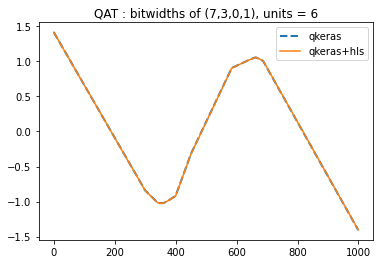

QAT : bitwidths of (7,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: q_dense_114_input, layer type: Input
Layer name: q_dense_114, layer type: QDense
Layer name: q_dense_115, layer type: QDense
Layer name: q_dense_116, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_114_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_114': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}, 'q_dense_115': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}, 'q_dense_116': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_114_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_114, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 8]
Layer name: q_dense_115, layer type: Q

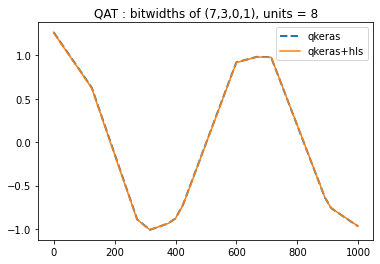

QAT : bitwidths of (7,3,0,1), units = 10
Interpreting Sequential
Topology:
Layer name: q_dense_117_input, layer type: Input
Layer name: q_dense_117, layer type: QDense
Layer name: q_dense_118, layer type: QDense
Layer name: q_dense_119, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_117_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_117': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}, 'q_dense_118': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}, 'q_dense_119': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_117_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_117, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_118, layer type:

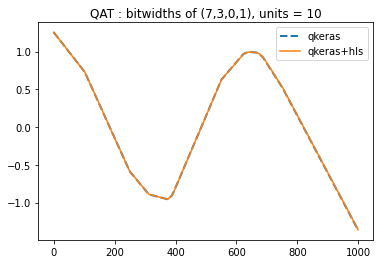

QAT : bitwidths of (7,3,0,1), units = 12
Interpreting Sequential
Topology:
Layer name: q_dense_120_input, layer type: Input
Layer name: q_dense_120, layer type: QDense
Layer name: q_dense_121, layer type: QDense
Layer name: q_dense_122, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_120_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_120': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}, 'q_dense_121': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}, 'q_dense_122': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_120_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_120, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 12]
Layer name: q_dense_121, layer type:

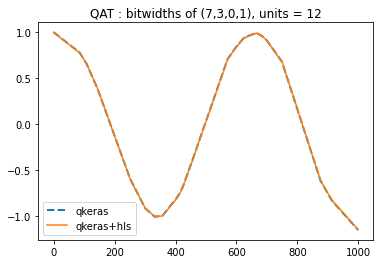

QAT : bitwidths of (7,3,0,1), units = 14
Interpreting Sequential
Topology:
Layer name: q_dense_123_input, layer type: Input
Layer name: q_dense_123, layer type: QDense
Layer name: q_dense_124, layer type: QDense
Layer name: q_dense_125, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_123_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_123': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}, 'q_dense_124': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}, 'q_dense_125': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_123_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_123, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 14]
Layer name: q_dense_124, layer type:

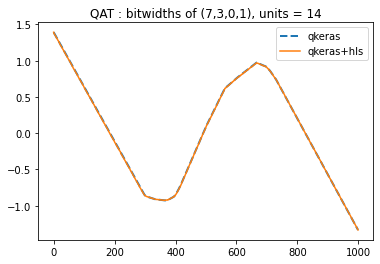

QAT : bitwidths of (7,3,0,1), units = 16
Interpreting Sequential
Topology:
Layer name: q_dense_126_input, layer type: Input
Layer name: q_dense_126, layer type: QDense
Layer name: q_dense_127, layer type: QDense
Layer name: q_dense_128, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_126_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_126': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}, 'q_dense_127': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}, 'q_dense_128': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_126_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_126, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 16]
Layer name: q_dense_127, layer type:

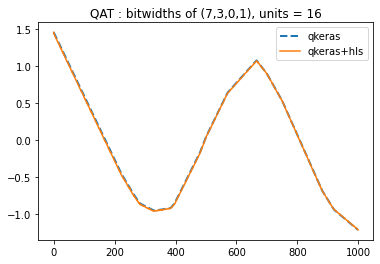

QAT : bitwidths of (7,3,0,1), units = 18
Interpreting Sequential
Topology:
Layer name: q_dense_129_input, layer type: Input
Layer name: q_dense_129, layer type: QDense
Layer name: q_dense_130, layer type: QDense
Layer name: q_dense_131, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_129_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_129': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}, 'q_dense_130': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}, 'q_dense_131': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_129_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_129, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 18]
Layer name: q_dense_130, layer type:

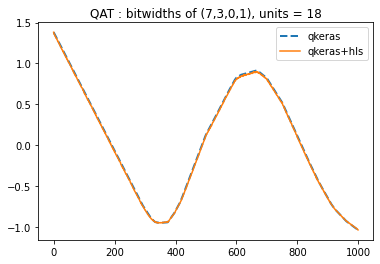

QAT : bitwidths of (7,3,0,1), units = 20
Interpreting Sequential
Topology:
Layer name: q_dense_132_input, layer type: Input
Layer name: q_dense_132, layer type: QDense
Layer name: q_dense_133, layer type: QDense
Layer name: q_dense_134, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_132_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_132': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}, 'q_dense_133': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}, 'q_dense_134': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_132_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_132, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 20]
Layer name: q_dense_133, layer type:

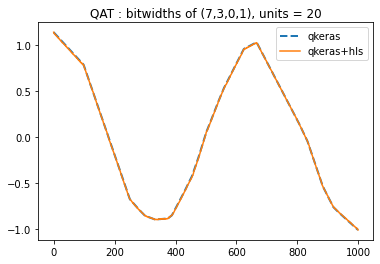

QAT : bitwidths of (7,3,0,1), units = 22
Interpreting Sequential
Topology:
Layer name: q_dense_135_input, layer type: Input
Layer name: q_dense_135, layer type: QDense
Layer name: q_dense_136, layer type: QDense
Layer name: q_dense_137, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_135_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_135': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}, 'q_dense_136': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}, 'q_dense_137': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_135_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_135, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 22]
Layer name: q_dense_136, layer type:

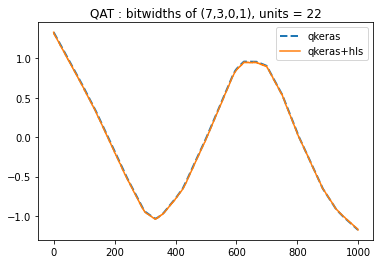

QAT : bitwidths of (7,3,0,1), units = 24
Interpreting Sequential
Topology:
Layer name: q_dense_138_input, layer type: Input
Layer name: q_dense_138, layer type: QDense
Layer name: q_dense_139, layer type: QDense
Layer name: q_dense_140, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_138_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_138': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}, 'q_dense_139': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}, 'q_dense_140': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_138_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_138, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 24]
Layer name: q_dense_139, layer type:

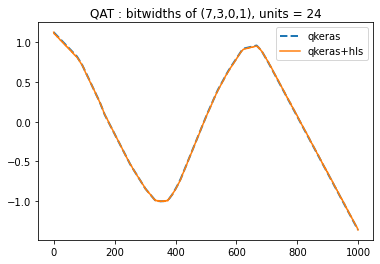

QAT : bitwidths of (7,3,0,1), units = 26
Interpreting Sequential
Topology:
Layer name: q_dense_141_input, layer type: Input
Layer name: q_dense_141, layer type: QDense
Layer name: q_dense_142, layer type: QDense
Layer name: q_dense_143, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_141_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_141': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}, 'q_dense_142': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}, 'q_dense_143': {'Precision': {'weight': 'ap_fixed<7,4>', 'bias': 'ap_fixed<7,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_141_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_141, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 26]
Layer name: q_dense_142, layer type:

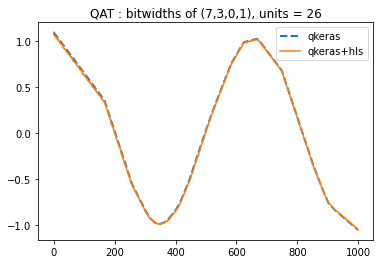

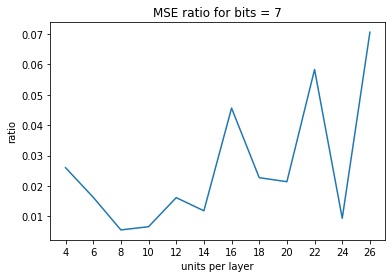

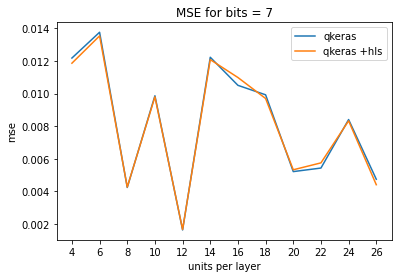

QAT : bitwidths of (8,3,0,1), units = 4
Interpreting Sequential
Topology:
Layer name: q_dense_144_input, layer type: Input
Layer name: q_dense_144, layer type: QDense
Layer name: q_dense_145, layer type: QDense
Layer name: q_dense_146, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_144_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_144': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}, 'q_dense_145': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}, 'q_dense_146': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_144_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_144, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 4]
Layer name: q_dense_145, layer type: Q

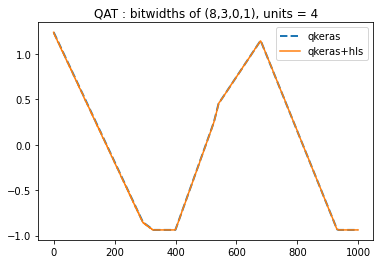

QAT : bitwidths of (8,3,0,1), units = 6
Interpreting Sequential
Topology:
Layer name: q_dense_147_input, layer type: Input
Layer name: q_dense_147, layer type: QDense
Layer name: q_dense_148, layer type: QDense
Layer name: q_dense_149, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_147_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_147': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}, 'q_dense_148': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}, 'q_dense_149': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_147_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_147, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 6]
Layer name: q_dense_148, layer type: Q

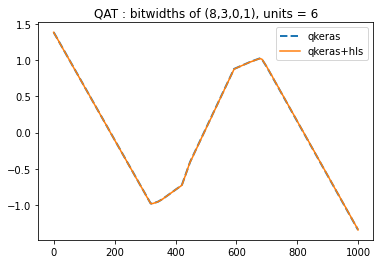

QAT : bitwidths of (8,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: q_dense_150_input, layer type: Input
Layer name: q_dense_150, layer type: QDense
Layer name: q_dense_151, layer type: QDense
Layer name: q_dense_152, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_150_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_150': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}, 'q_dense_151': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}, 'q_dense_152': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_150_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_150, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 8]
Layer name: q_dense_151, layer type: Q

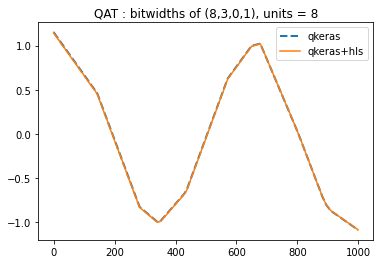

QAT : bitwidths of (8,3,0,1), units = 10
Interpreting Sequential
Topology:
Layer name: q_dense_153_input, layer type: Input
Layer name: q_dense_153, layer type: QDense
Layer name: q_dense_154, layer type: QDense
Layer name: q_dense_155, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_153_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_153': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}, 'q_dense_154': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}, 'q_dense_155': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_153_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_153, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_154, layer type:

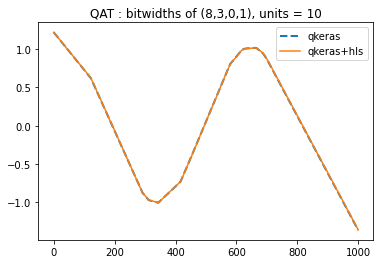

QAT : bitwidths of (8,3,0,1), units = 12
Interpreting Sequential
Topology:
Layer name: q_dense_156_input, layer type: Input
Layer name: q_dense_156, layer type: QDense
Layer name: q_dense_157, layer type: QDense
Layer name: q_dense_158, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_156_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_156': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}, 'q_dense_157': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}, 'q_dense_158': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_156_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_156, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 12]
Layer name: q_dense_157, layer type:

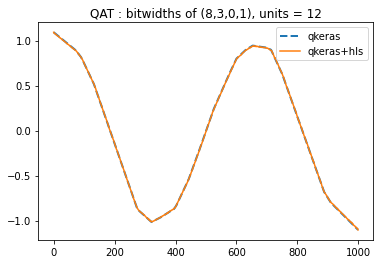

QAT : bitwidths of (8,3,0,1), units = 14
Interpreting Sequential
Topology:
Layer name: q_dense_159_input, layer type: Input
Layer name: q_dense_159, layer type: QDense
Layer name: q_dense_160, layer type: QDense
Layer name: q_dense_161, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_159_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_159': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}, 'q_dense_160': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}, 'q_dense_161': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_159_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_159, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 14]
Layer name: q_dense_160, layer type:

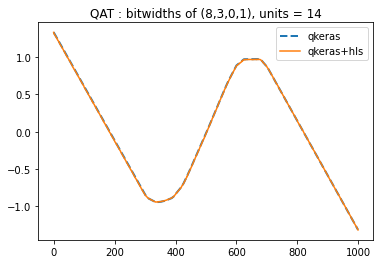

QAT : bitwidths of (8,3,0,1), units = 16
Interpreting Sequential
Topology:
Layer name: q_dense_162_input, layer type: Input
Layer name: q_dense_162, layer type: QDense
Layer name: q_dense_163, layer type: QDense
Layer name: q_dense_164, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_162_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_162': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}, 'q_dense_163': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}, 'q_dense_164': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_162_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_162, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 16]
Layer name: q_dense_163, layer type:

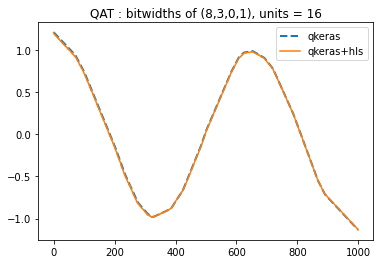

QAT : bitwidths of (8,3,0,1), units = 18
Interpreting Sequential
Topology:
Layer name: q_dense_165_input, layer type: Input
Layer name: q_dense_165, layer type: QDense
Layer name: q_dense_166, layer type: QDense
Layer name: q_dense_167, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_165_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_165': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}, 'q_dense_166': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}, 'q_dense_167': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_165_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_165, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 18]
Layer name: q_dense_166, layer type:

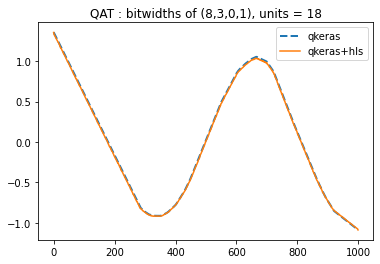

QAT : bitwidths of (8,3,0,1), units = 20
Interpreting Sequential
Topology:
Layer name: q_dense_168_input, layer type: Input
Layer name: q_dense_168, layer type: QDense
Layer name: q_dense_169, layer type: QDense
Layer name: q_dense_170, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_168_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_168': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}, 'q_dense_169': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}, 'q_dense_170': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_168_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_168, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 20]
Layer name: q_dense_169, layer type:

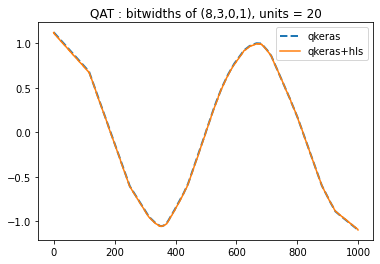

QAT : bitwidths of (8,3,0,1), units = 22
Interpreting Sequential
Topology:
Layer name: q_dense_171_input, layer type: Input
Layer name: q_dense_171, layer type: QDense
Layer name: q_dense_172, layer type: QDense
Layer name: q_dense_173, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_171_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_171': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}, 'q_dense_172': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}, 'q_dense_173': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_171_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_171, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 22]
Layer name: q_dense_172, layer type:

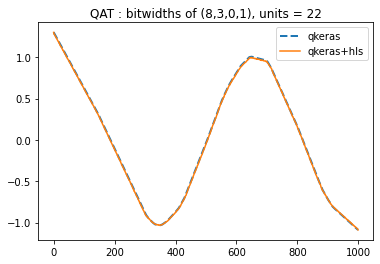

QAT : bitwidths of (8,3,0,1), units = 24
Interpreting Sequential
Topology:
Layer name: q_dense_174_input, layer type: Input
Layer name: q_dense_174, layer type: QDense
Layer name: q_dense_175, layer type: QDense
Layer name: q_dense_176, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_174_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_174': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}, 'q_dense_175': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}, 'q_dense_176': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_174_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_174, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 24]
Layer name: q_dense_175, layer type:

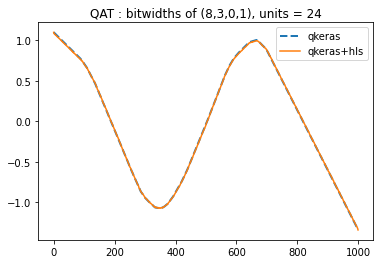

QAT : bitwidths of (8,3,0,1), units = 26
Interpreting Sequential
Topology:
Layer name: q_dense_177_input, layer type: Input
Layer name: q_dense_177, layer type: QDense
Layer name: q_dense_178, layer type: QDense
Layer name: q_dense_179, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_177_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_177': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}, 'q_dense_178': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}, 'q_dense_179': {'Precision': {'weight': 'ap_fixed<8,4>', 'bias': 'ap_fixed<8,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_177_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_177, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 26]
Layer name: q_dense_178, layer type:

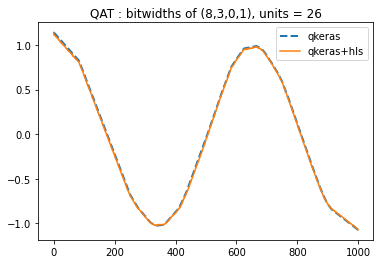

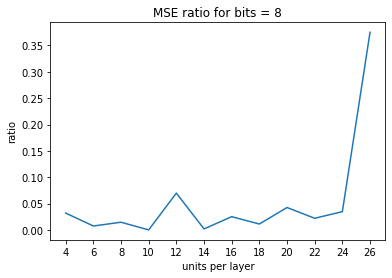

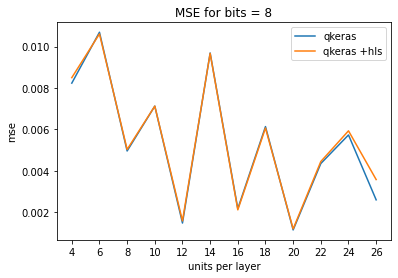

QAT : bitwidths of (9,3,0,1), units = 4
Interpreting Sequential
Topology:
Layer name: q_dense_180_input, layer type: Input
Layer name: q_dense_180, layer type: QDense
Layer name: q_dense_181, layer type: QDense
Layer name: q_dense_182, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_180_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_180': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_181': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_182': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_180_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_180, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 4]
Layer name: q_dense_181, layer type: Q

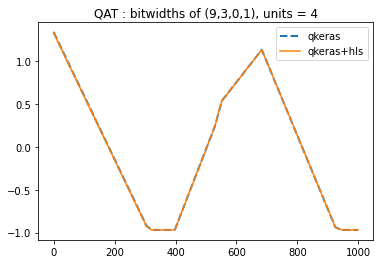

QAT : bitwidths of (9,3,0,1), units = 6
Interpreting Sequential
Topology:
Layer name: q_dense_183_input, layer type: Input
Layer name: q_dense_183, layer type: QDense
Layer name: q_dense_184, layer type: QDense
Layer name: q_dense_185, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_183_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_183': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_184': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_185': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_183_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_183, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 6]
Layer name: q_dense_184, layer type: Q

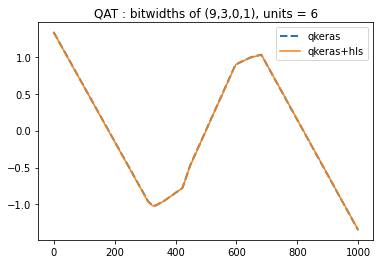

QAT : bitwidths of (9,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: q_dense_186_input, layer type: Input
Layer name: q_dense_186, layer type: QDense
Layer name: q_dense_187, layer type: QDense
Layer name: q_dense_188, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_186_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_186': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_187': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_188': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_186_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_186, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 8]
Layer name: q_dense_187, layer type: Q

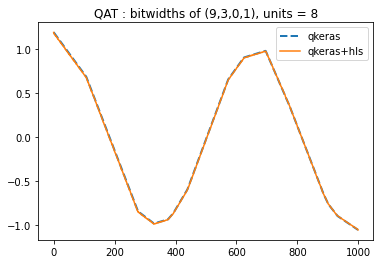

QAT : bitwidths of (9,3,0,1), units = 10
Interpreting Sequential
Topology:
Layer name: q_dense_189_input, layer type: Input
Layer name: q_dense_189, layer type: QDense
Layer name: q_dense_190, layer type: QDense
Layer name: q_dense_191, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_189_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_189': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_190': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_191': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_189_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_189, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_190, layer type:

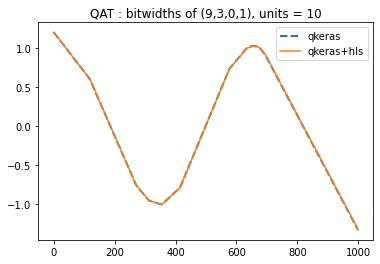

QAT : bitwidths of (9,3,0,1), units = 12
Interpreting Sequential
Topology:
Layer name: q_dense_192_input, layer type: Input
Layer name: q_dense_192, layer type: QDense
Layer name: q_dense_193, layer type: QDense
Layer name: q_dense_194, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_192_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_192': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_193': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_194': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_192_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_192, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 12]
Layer name: q_dense_193, layer type:

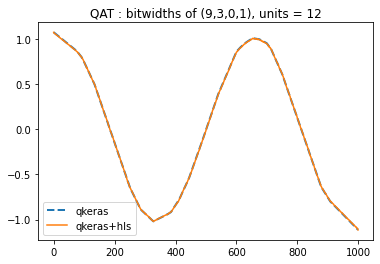

QAT : bitwidths of (9,3,0,1), units = 14
Interpreting Sequential
Topology:
Layer name: q_dense_195_input, layer type: Input
Layer name: q_dense_195, layer type: QDense
Layer name: q_dense_196, layer type: QDense
Layer name: q_dense_197, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_195_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_195': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_196': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_197': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_195_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_195, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 14]
Layer name: q_dense_196, layer type:

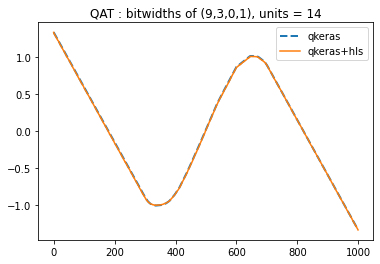

QAT : bitwidths of (9,3,0,1), units = 16
Interpreting Sequential
Topology:
Layer name: q_dense_198_input, layer type: Input
Layer name: q_dense_198, layer type: QDense
Layer name: q_dense_199, layer type: QDense
Layer name: q_dense_200, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_198_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_198': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_199': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_200': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_198_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_198, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 16]
Layer name: q_dense_199, layer type:

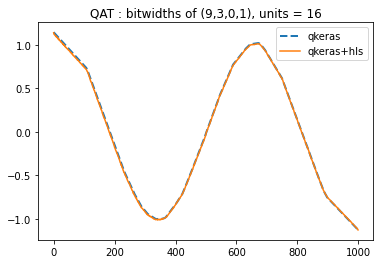

QAT : bitwidths of (9,3,0,1), units = 18
Interpreting Sequential
Topology:
Layer name: q_dense_201_input, layer type: Input
Layer name: q_dense_201, layer type: QDense
Layer name: q_dense_202, layer type: QDense
Layer name: q_dense_203, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_201_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_201': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_202': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_203': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_201_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_201, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 18]
Layer name: q_dense_202, layer type:

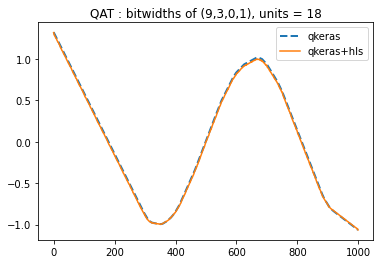

QAT : bitwidths of (9,3,0,1), units = 20
Interpreting Sequential
Topology:
Layer name: q_dense_204_input, layer type: Input
Layer name: q_dense_204, layer type: QDense
Layer name: q_dense_205, layer type: QDense
Layer name: q_dense_206, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_204_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_204': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_205': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_206': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_204_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_204, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 20]
Layer name: q_dense_205, layer type:

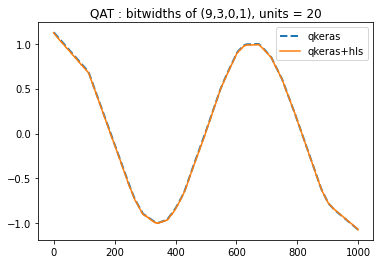

QAT : bitwidths of (9,3,0,1), units = 22
Interpreting Sequential
Topology:
Layer name: q_dense_207_input, layer type: Input
Layer name: q_dense_207, layer type: QDense
Layer name: q_dense_208, layer type: QDense
Layer name: q_dense_209, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_207_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_207': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_208': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_209': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_207_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_207, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 22]
Layer name: q_dense_208, layer type:

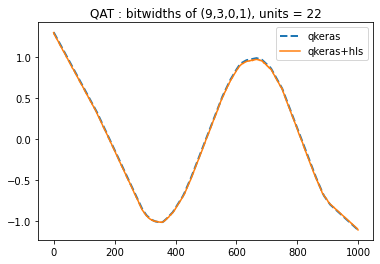

QAT : bitwidths of (9,3,0,1), units = 24
Interpreting Sequential
Topology:
Layer name: q_dense_210_input, layer type: Input
Layer name: q_dense_210, layer type: QDense
Layer name: q_dense_211, layer type: QDense
Layer name: q_dense_212, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_210_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_210': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_211': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_212': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_210_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_210, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 24]
Layer name: q_dense_211, layer type:

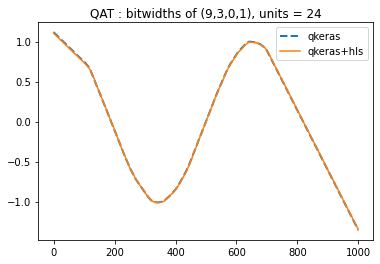

QAT : bitwidths of (9,3,0,1), units = 26
Interpreting Sequential
Topology:
Layer name: q_dense_213_input, layer type: Input
Layer name: q_dense_213, layer type: QDense
Layer name: q_dense_214, layer type: QDense
Layer name: q_dense_215, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_213_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_213': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_214': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_215': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_213_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_213, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 26]
Layer name: q_dense_214, layer type:

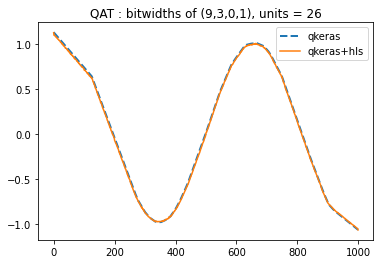

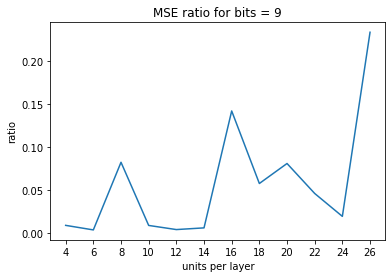

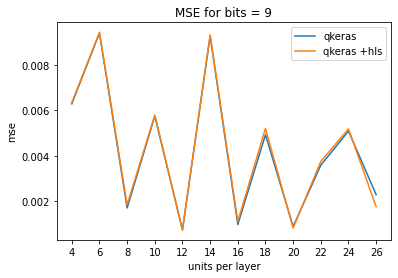

QAT : bitwidths of (10,3,0,1), units = 4
Interpreting Sequential
Topology:
Layer name: q_dense_216_input, layer type: Input
Layer name: q_dense_216, layer type: QDense
Layer name: q_dense_217, layer type: QDense
Layer name: q_dense_218, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_216_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_216': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}, 'q_dense_217': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}, 'q_dense_218': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_216_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_216, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 4]
Layer name: q_dense_217, layer 

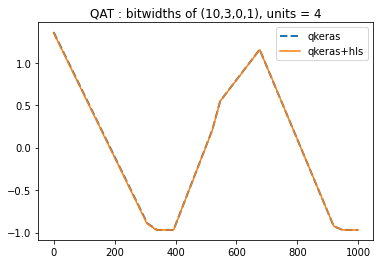

QAT : bitwidths of (10,3,0,1), units = 6
Interpreting Sequential
Topology:
Layer name: q_dense_219_input, layer type: Input
Layer name: q_dense_219, layer type: QDense
Layer name: q_dense_220, layer type: QDense
Layer name: q_dense_221, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_219_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_219': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}, 'q_dense_220': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}, 'q_dense_221': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_219_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_219, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 6]
Layer name: q_dense_220, layer 

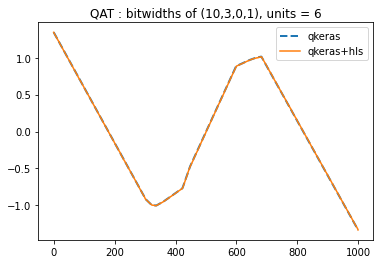

QAT : bitwidths of (10,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: q_dense_222_input, layer type: Input
Layer name: q_dense_222, layer type: QDense
Layer name: q_dense_223, layer type: QDense
Layer name: q_dense_224, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_222_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_222': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}, 'q_dense_223': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}, 'q_dense_224': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_222_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_222, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 8]
Layer name: q_dense_223, layer 

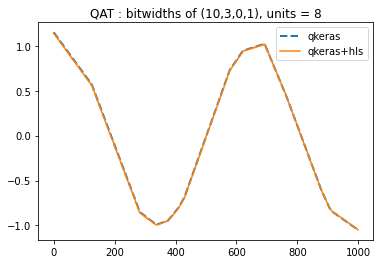

QAT : bitwidths of (10,3,0,1), units = 10
Interpreting Sequential
Topology:
Layer name: q_dense_225_input, layer type: Input
Layer name: q_dense_225, layer type: QDense
Layer name: q_dense_226, layer type: QDense
Layer name: q_dense_227, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_225_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_225': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}, 'q_dense_226': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}, 'q_dense_227': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_225_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_225, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_226, laye

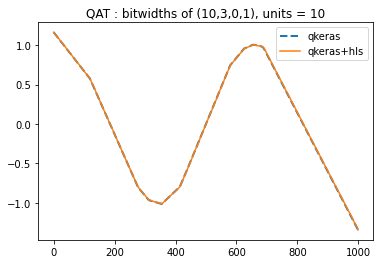

QAT : bitwidths of (10,3,0,1), units = 12
Interpreting Sequential
Topology:
Layer name: q_dense_228_input, layer type: Input
Layer name: q_dense_228, layer type: QDense
Layer name: q_dense_229, layer type: QDense
Layer name: q_dense_230, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_228_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_228': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}, 'q_dense_229': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}, 'q_dense_230': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_228_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_228, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 12]
Layer name: q_dense_229, laye

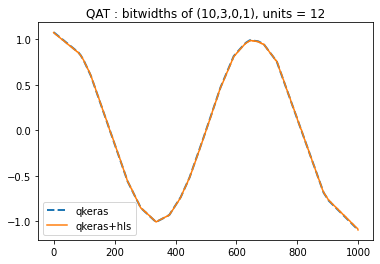

QAT : bitwidths of (10,3,0,1), units = 14
Interpreting Sequential
Topology:
Layer name: q_dense_231_input, layer type: Input
Layer name: q_dense_231, layer type: QDense
Layer name: q_dense_232, layer type: QDense
Layer name: q_dense_233, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_231_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_231': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}, 'q_dense_232': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}, 'q_dense_233': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_231_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_231, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 14]
Layer name: q_dense_232, laye

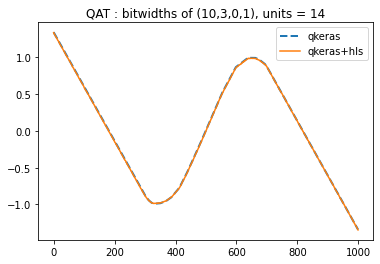

QAT : bitwidths of (10,3,0,1), units = 16
Interpreting Sequential
Topology:
Layer name: q_dense_234_input, layer type: Input
Layer name: q_dense_234, layer type: QDense
Layer name: q_dense_235, layer type: QDense
Layer name: q_dense_236, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_234_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_234': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}, 'q_dense_235': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}, 'q_dense_236': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_234_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_234, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 16]
Layer name: q_dense_235, laye

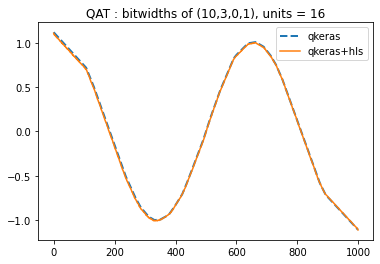

QAT : bitwidths of (10,3,0,1), units = 18
Interpreting Sequential
Topology:
Layer name: q_dense_237_input, layer type: Input
Layer name: q_dense_237, layer type: QDense
Layer name: q_dense_238, layer type: QDense
Layer name: q_dense_239, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_237_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_237': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}, 'q_dense_238': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}, 'q_dense_239': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_237_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_237, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 18]
Layer name: q_dense_238, laye

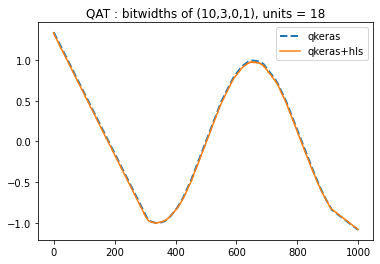

QAT : bitwidths of (10,3,0,1), units = 20
Interpreting Sequential
Topology:
Layer name: q_dense_240_input, layer type: Input
Layer name: q_dense_240, layer type: QDense
Layer name: q_dense_241, layer type: QDense
Layer name: q_dense_242, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_240_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_240': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}, 'q_dense_241': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}, 'q_dense_242': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_240_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_240, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 20]
Layer name: q_dense_241, laye

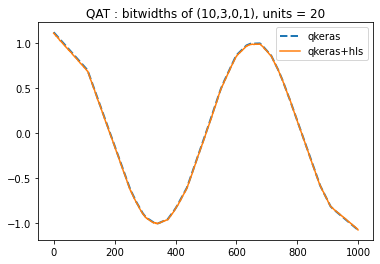

QAT : bitwidths of (10,3,0,1), units = 22
Interpreting Sequential
Topology:
Layer name: q_dense_243_input, layer type: Input
Layer name: q_dense_243, layer type: QDense
Layer name: q_dense_244, layer type: QDense
Layer name: q_dense_245, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_243_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_243': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}, 'q_dense_244': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}, 'q_dense_245': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_243_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_243, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 22]
Layer name: q_dense_244, laye

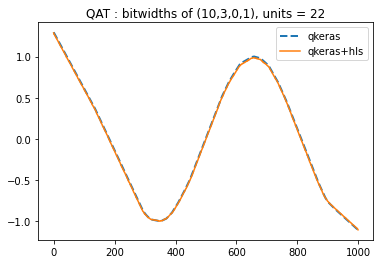

QAT : bitwidths of (10,3,0,1), units = 24
Interpreting Sequential
Topology:
Layer name: q_dense_246_input, layer type: Input
Layer name: q_dense_246, layer type: QDense
Layer name: q_dense_247, layer type: QDense
Layer name: q_dense_248, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_246_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_246': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}, 'q_dense_247': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}, 'q_dense_248': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_246_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_246, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 24]
Layer name: q_dense_247, laye

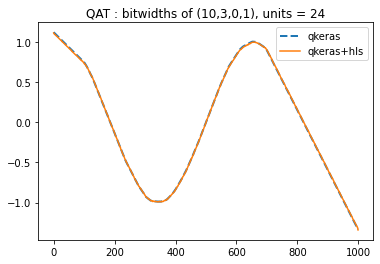

QAT : bitwidths of (10,3,0,1), units = 26
Interpreting Sequential
Topology:
Layer name: q_dense_249_input, layer type: Input
Layer name: q_dense_249, layer type: QDense
Layer name: q_dense_250, layer type: QDense
Layer name: q_dense_251, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_249_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_249': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}, 'q_dense_250': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}, 'q_dense_251': {'Precision': {'weight': 'ap_fixed<10,4>', 'bias': 'ap_fixed<10,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_249_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_249, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 26]
Layer name: q_dense_250, laye

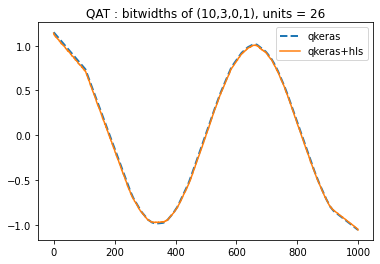

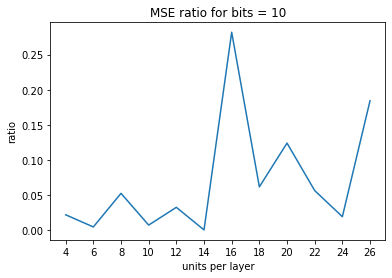

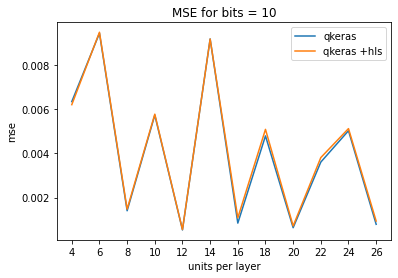

QAT : bitwidths of (11,3,0,1), units = 4
Interpreting Sequential
Topology:
Layer name: q_dense_252_input, layer type: Input
Layer name: q_dense_252, layer type: QDense
Layer name: q_dense_253, layer type: QDense
Layer name: q_dense_254, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_252_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_252': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}, 'q_dense_253': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}, 'q_dense_254': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_252_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_252, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 4]
Layer name: q_dense_253, layer 

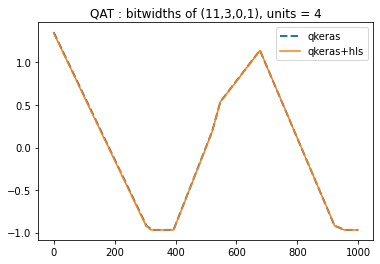

QAT : bitwidths of (11,3,0,1), units = 6
Interpreting Sequential
Topology:
Layer name: q_dense_255_input, layer type: Input
Layer name: q_dense_255, layer type: QDense
Layer name: q_dense_256, layer type: QDense
Layer name: q_dense_257, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_255_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_255': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}, 'q_dense_256': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}, 'q_dense_257': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_255_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_255, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 6]
Layer name: q_dense_256, layer 

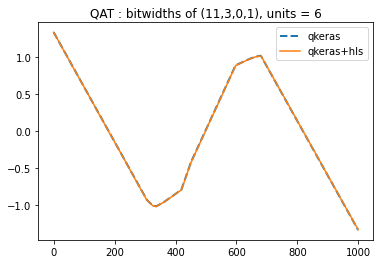

QAT : bitwidths of (11,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: q_dense_258_input, layer type: Input
Layer name: q_dense_258, layer type: QDense
Layer name: q_dense_259, layer type: QDense
Layer name: q_dense_260, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_258_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_258': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}, 'q_dense_259': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}, 'q_dense_260': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_258_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_258, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 8]
Layer name: q_dense_259, layer 

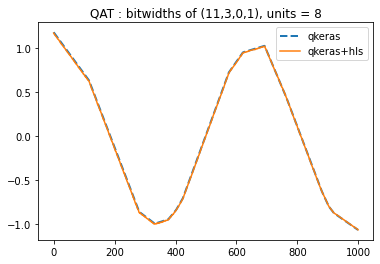

QAT : bitwidths of (11,3,0,1), units = 10
Interpreting Sequential
Topology:
Layer name: q_dense_261_input, layer type: Input
Layer name: q_dense_261, layer type: QDense
Layer name: q_dense_262, layer type: QDense
Layer name: q_dense_263, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_261_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_261': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}, 'q_dense_262': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}, 'q_dense_263': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_261_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_261, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_262, laye

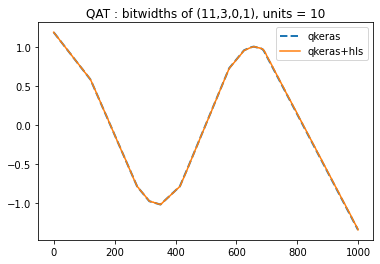

QAT : bitwidths of (11,3,0,1), units = 12
Interpreting Sequential
Topology:
Layer name: q_dense_264_input, layer type: Input
Layer name: q_dense_264, layer type: QDense
Layer name: q_dense_265, layer type: QDense
Layer name: q_dense_266, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_264_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_264': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}, 'q_dense_265': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}, 'q_dense_266': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_264_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_264, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 12]
Layer name: q_dense_265, laye

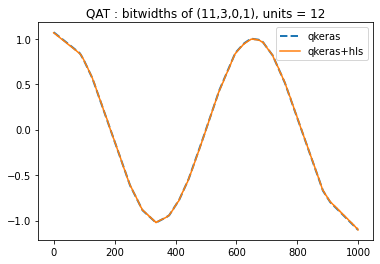

QAT : bitwidths of (11,3,0,1), units = 14
Interpreting Sequential
Topology:
Layer name: q_dense_267_input, layer type: Input
Layer name: q_dense_267, layer type: QDense
Layer name: q_dense_268, layer type: QDense
Layer name: q_dense_269, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_267_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_267': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}, 'q_dense_268': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}, 'q_dense_269': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_267_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_267, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 14]
Layer name: q_dense_268, laye

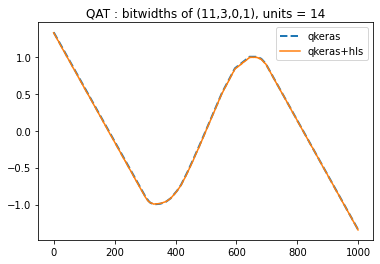

QAT : bitwidths of (11,3,0,1), units = 16
Interpreting Sequential
Topology:
Layer name: q_dense_270_input, layer type: Input
Layer name: q_dense_270, layer type: QDense
Layer name: q_dense_271, layer type: QDense
Layer name: q_dense_272, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_270_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_270': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}, 'q_dense_271': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}, 'q_dense_272': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_270_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_270, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 16]
Layer name: q_dense_271, laye

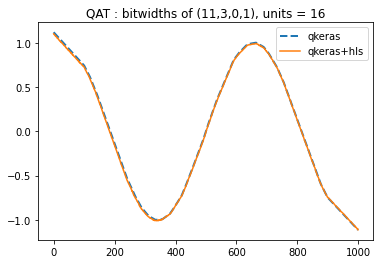

QAT : bitwidths of (11,3,0,1), units = 18
Interpreting Sequential
Topology:
Layer name: q_dense_273_input, layer type: Input
Layer name: q_dense_273, layer type: QDense
Layer name: q_dense_274, layer type: QDense
Layer name: q_dense_275, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_273_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_273': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}, 'q_dense_274': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}, 'q_dense_275': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_273_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_273, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 18]
Layer name: q_dense_274, laye

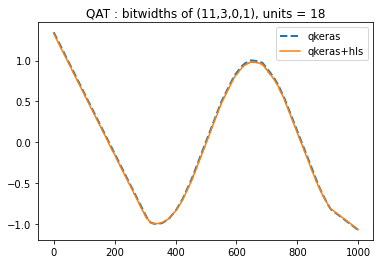

QAT : bitwidths of (11,3,0,1), units = 20
Interpreting Sequential
Topology:
Layer name: q_dense_276_input, layer type: Input
Layer name: q_dense_276, layer type: QDense
Layer name: q_dense_277, layer type: QDense
Layer name: q_dense_278, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_276_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_276': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}, 'q_dense_277': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}, 'q_dense_278': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_276_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_276, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 20]
Layer name: q_dense_277, laye

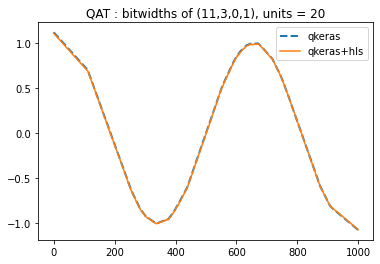

QAT : bitwidths of (11,3,0,1), units = 22
Interpreting Sequential
Topology:
Layer name: q_dense_279_input, layer type: Input
Layer name: q_dense_279, layer type: QDense
Layer name: q_dense_280, layer type: QDense
Layer name: q_dense_281, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_279_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_279': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}, 'q_dense_280': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}, 'q_dense_281': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_279_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_279, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 22]
Layer name: q_dense_280, laye

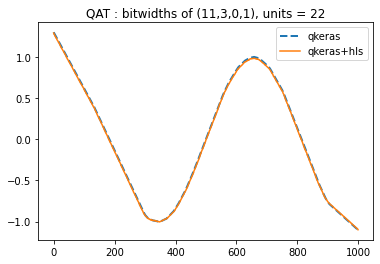

QAT : bitwidths of (11,3,0,1), units = 24
Interpreting Sequential
Topology:
Layer name: q_dense_282_input, layer type: Input
Layer name: q_dense_282, layer type: QDense
Layer name: q_dense_283, layer type: QDense
Layer name: q_dense_284, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_282_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_282': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}, 'q_dense_283': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}, 'q_dense_284': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_282_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_282, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 24]
Layer name: q_dense_283, laye

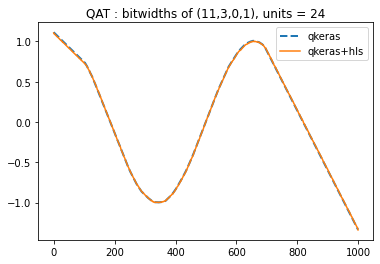

QAT : bitwidths of (11,3,0,1), units = 26
Interpreting Sequential
Topology:
Layer name: q_dense_285_input, layer type: Input
Layer name: q_dense_285, layer type: QDense
Layer name: q_dense_286, layer type: QDense
Layer name: q_dense_287, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_285_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_285': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}, 'q_dense_286': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}, 'q_dense_287': {'Precision': {'weight': 'ap_fixed<11,4>', 'bias': 'ap_fixed<11,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_285_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_285, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 26]
Layer name: q_dense_286, laye

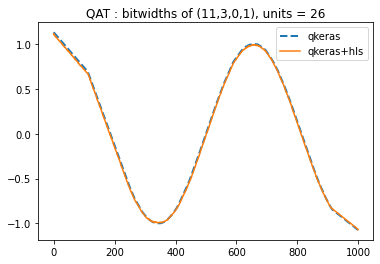

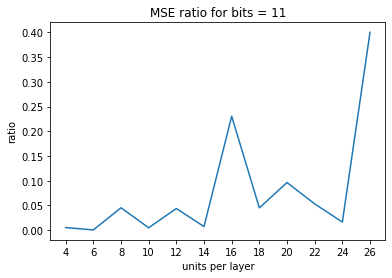

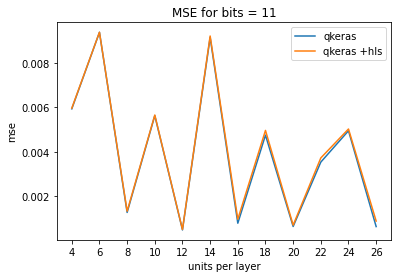

QAT : bitwidths of (12,3,0,1), units = 4
Interpreting Sequential
Topology:
Layer name: q_dense_288_input, layer type: Input
Layer name: q_dense_288, layer type: QDense
Layer name: q_dense_289, layer type: QDense
Layer name: q_dense_290, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_288_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_288': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_289': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_290': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_288_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_288, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 4]
Layer name: q_dense_289, layer 

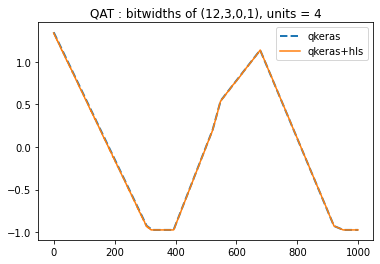

QAT : bitwidths of (12,3,0,1), units = 6
Interpreting Sequential
Topology:
Layer name: q_dense_291_input, layer type: Input
Layer name: q_dense_291, layer type: QDense
Layer name: q_dense_292, layer type: QDense
Layer name: q_dense_293, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_291_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_291': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_292': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_293': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_291_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_291, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 6]
Layer name: q_dense_292, layer 

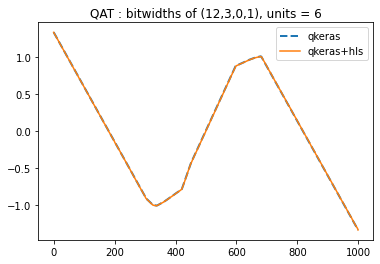

QAT : bitwidths of (12,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: q_dense_294_input, layer type: Input
Layer name: q_dense_294, layer type: QDense
Layer name: q_dense_295, layer type: QDense
Layer name: q_dense_296, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_294_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_294': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_295': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_296': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_294_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_294, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 8]
Layer name: q_dense_295, layer 

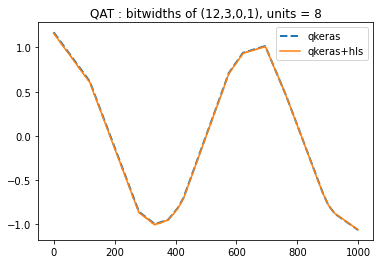

QAT : bitwidths of (12,3,0,1), units = 10
Interpreting Sequential
Topology:
Layer name: q_dense_297_input, layer type: Input
Layer name: q_dense_297, layer type: QDense
Layer name: q_dense_298, layer type: QDense
Layer name: q_dense_299, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_297_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_297': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_298': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_299': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_297_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_297, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_298, laye

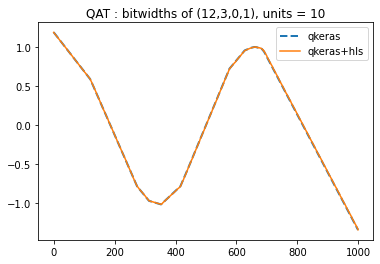

QAT : bitwidths of (12,3,0,1), units = 12
Interpreting Sequential
Topology:
Layer name: q_dense_300_input, layer type: Input
Layer name: q_dense_300, layer type: QDense
Layer name: q_dense_301, layer type: QDense
Layer name: q_dense_302, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_300_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_300': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_301': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_302': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_300_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_300, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 12]
Layer name: q_dense_301, laye

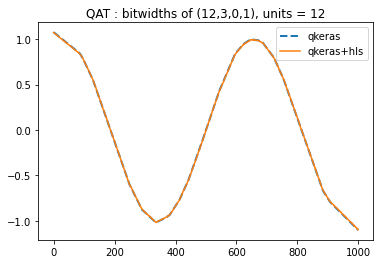

QAT : bitwidths of (12,3,0,1), units = 14
Interpreting Sequential
Topology:
Layer name: q_dense_303_input, layer type: Input
Layer name: q_dense_303, layer type: QDense
Layer name: q_dense_304, layer type: QDense
Layer name: q_dense_305, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_303_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_303': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_304': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_305': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_303_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_303, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 14]
Layer name: q_dense_304, laye

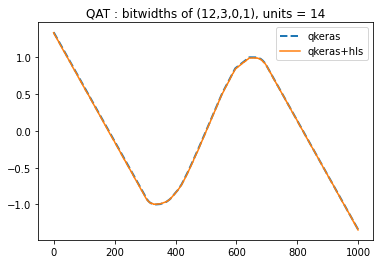

QAT : bitwidths of (12,3,0,1), units = 16
Interpreting Sequential
Topology:
Layer name: q_dense_306_input, layer type: Input
Layer name: q_dense_306, layer type: QDense
Layer name: q_dense_307, layer type: QDense
Layer name: q_dense_308, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_306_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_306': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_307': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_308': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_306_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_306, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 16]
Layer name: q_dense_307, laye

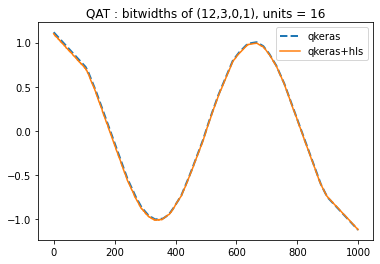

QAT : bitwidths of (12,3,0,1), units = 18
Interpreting Sequential
Topology:
Layer name: q_dense_309_input, layer type: Input
Layer name: q_dense_309, layer type: QDense
Layer name: q_dense_310, layer type: QDense
Layer name: q_dense_311, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_309_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_309': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_310': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_311': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_309_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_309, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 18]
Layer name: q_dense_310, laye

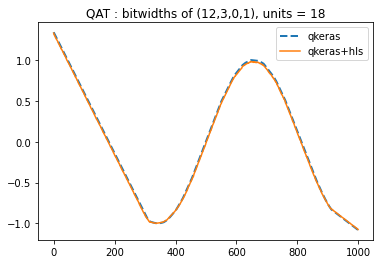

QAT : bitwidths of (12,3,0,1), units = 20
Interpreting Sequential
Topology:
Layer name: q_dense_312_input, layer type: Input
Layer name: q_dense_312, layer type: QDense
Layer name: q_dense_313, layer type: QDense
Layer name: q_dense_314, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_312_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_312': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_313': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_314': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_312_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_312, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 20]
Layer name: q_dense_313, laye

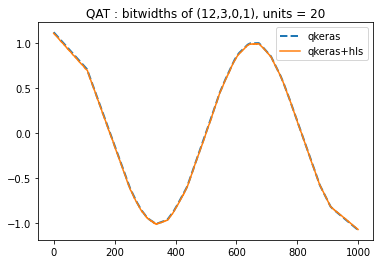

QAT : bitwidths of (12,3,0,1), units = 22
Interpreting Sequential
Topology:
Layer name: q_dense_315_input, layer type: Input
Layer name: q_dense_315, layer type: QDense
Layer name: q_dense_316, layer type: QDense
Layer name: q_dense_317, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_315_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_315': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_316': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_317': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_315_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_315, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 22]
Layer name: q_dense_316, laye

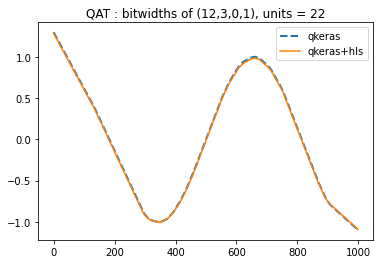

QAT : bitwidths of (12,3,0,1), units = 24
Interpreting Sequential
Topology:
Layer name: q_dense_318_input, layer type: Input
Layer name: q_dense_318, layer type: QDense
Layer name: q_dense_319, layer type: QDense
Layer name: q_dense_320, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_318_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_318': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_319': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_320': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_318_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_318, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 24]
Layer name: q_dense_319, laye

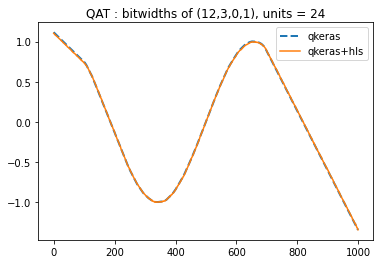

QAT : bitwidths of (12,3,0,1), units = 26
Interpreting Sequential
Topology:
Layer name: q_dense_321_input, layer type: Input
Layer name: q_dense_321, layer type: QDense
Layer name: q_dense_322, layer type: QDense
Layer name: q_dense_323, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_321_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_321': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_322': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_323': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_321_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_321, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 26]
Layer name: q_dense_322, laye

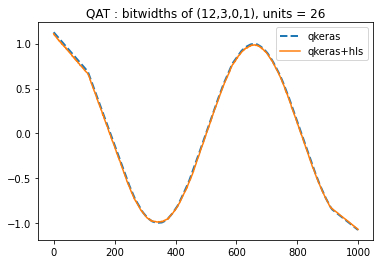

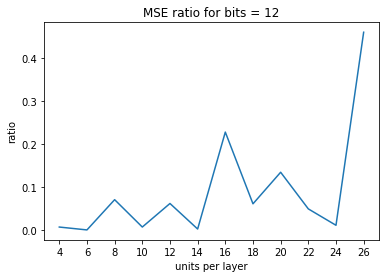

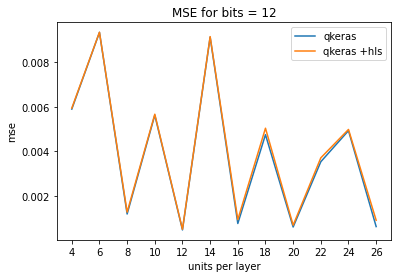

QAT : bitwidths of (13,3,0,1), units = 4
Interpreting Sequential
Topology:
Layer name: q_dense_324_input, layer type: Input
Layer name: q_dense_324, layer type: QDense
Layer name: q_dense_325, layer type: QDense
Layer name: q_dense_326, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_324_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_324': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}, 'q_dense_325': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}, 'q_dense_326': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_324_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_324, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 4]
Layer name: q_dense_325, layer 

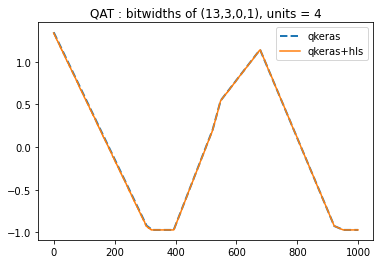

QAT : bitwidths of (13,3,0,1), units = 6
Interpreting Sequential
Topology:
Layer name: q_dense_327_input, layer type: Input
Layer name: q_dense_327, layer type: QDense
Layer name: q_dense_328, layer type: QDense
Layer name: q_dense_329, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_327_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_327': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}, 'q_dense_328': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}, 'q_dense_329': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_327_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_327, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 6]
Layer name: q_dense_328, layer 

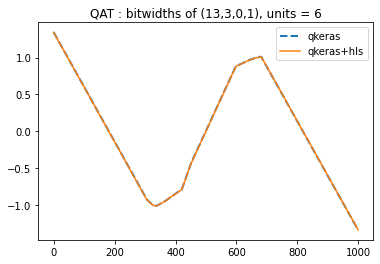

QAT : bitwidths of (13,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: q_dense_330_input, layer type: Input
Layer name: q_dense_330, layer type: QDense
Layer name: q_dense_331, layer type: QDense
Layer name: q_dense_332, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_330_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_330': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}, 'q_dense_331': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}, 'q_dense_332': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_330_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_330, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 8]
Layer name: q_dense_331, layer 

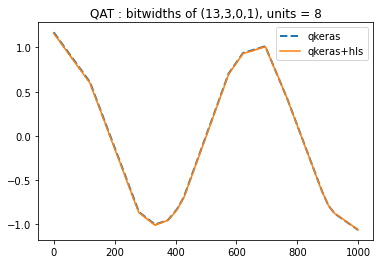

QAT : bitwidths of (13,3,0,1), units = 10
Interpreting Sequential
Topology:
Layer name: q_dense_333_input, layer type: Input
Layer name: q_dense_333, layer type: QDense
Layer name: q_dense_334, layer type: QDense
Layer name: q_dense_335, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_333_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_333': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}, 'q_dense_334': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}, 'q_dense_335': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_333_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_333, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_334, laye

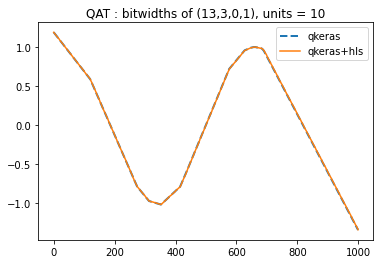

QAT : bitwidths of (13,3,0,1), units = 12
Interpreting Sequential
Topology:
Layer name: q_dense_336_input, layer type: Input
Layer name: q_dense_336, layer type: QDense
Layer name: q_dense_337, layer type: QDense
Layer name: q_dense_338, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_336_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_336': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}, 'q_dense_337': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}, 'q_dense_338': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_336_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_336, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 12]
Layer name: q_dense_337, laye

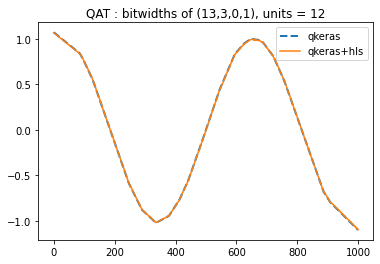

QAT : bitwidths of (13,3,0,1), units = 14
Interpreting Sequential
Topology:
Layer name: q_dense_339_input, layer type: Input
Layer name: q_dense_339, layer type: QDense
Layer name: q_dense_340, layer type: QDense
Layer name: q_dense_341, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_339_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_339': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}, 'q_dense_340': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}, 'q_dense_341': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_339_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_339, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 14]
Layer name: q_dense_340, laye

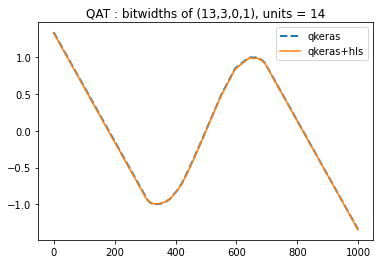

QAT : bitwidths of (13,3,0,1), units = 16
Interpreting Sequential
Topology:
Layer name: q_dense_342_input, layer type: Input
Layer name: q_dense_342, layer type: QDense
Layer name: q_dense_343, layer type: QDense
Layer name: q_dense_344, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_342_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_342': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}, 'q_dense_343': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}, 'q_dense_344': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_342_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_342, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 16]
Layer name: q_dense_343, laye

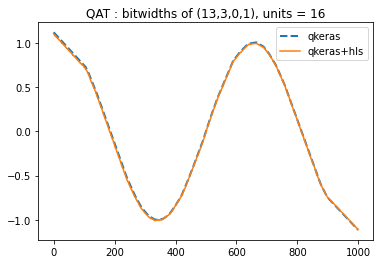

QAT : bitwidths of (13,3,0,1), units = 18
Interpreting Sequential
Topology:
Layer name: q_dense_345_input, layer type: Input
Layer name: q_dense_345, layer type: QDense
Layer name: q_dense_346, layer type: QDense
Layer name: q_dense_347, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_345_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_345': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}, 'q_dense_346': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}, 'q_dense_347': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_345_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_345, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 18]
Layer name: q_dense_346, laye

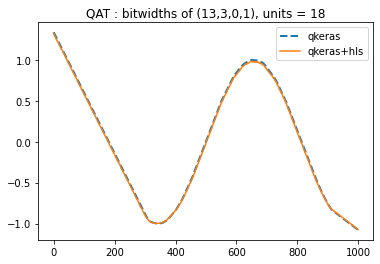

QAT : bitwidths of (13,3,0,1), units = 20
Interpreting Sequential
Topology:
Layer name: q_dense_348_input, layer type: Input
Layer name: q_dense_348, layer type: QDense
Layer name: q_dense_349, layer type: QDense
Layer name: q_dense_350, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_348_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_348': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}, 'q_dense_349': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}, 'q_dense_350': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_348_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_348, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 20]
Layer name: q_dense_349, laye

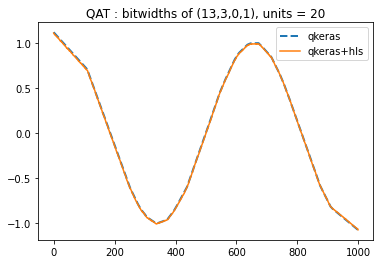

QAT : bitwidths of (13,3,0,1), units = 22
Interpreting Sequential
Topology:
Layer name: q_dense_351_input, layer type: Input
Layer name: q_dense_351, layer type: QDense
Layer name: q_dense_352, layer type: QDense
Layer name: q_dense_353, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_351_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_351': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}, 'q_dense_352': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}, 'q_dense_353': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_351_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_351, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 22]
Layer name: q_dense_352, laye

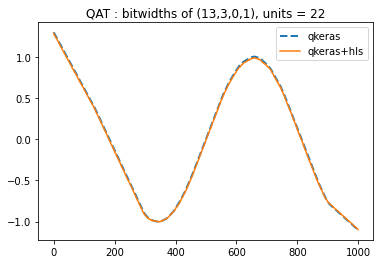

QAT : bitwidths of (13,3,0,1), units = 24
Interpreting Sequential
Topology:
Layer name: q_dense_354_input, layer type: Input
Layer name: q_dense_354, layer type: QDense
Layer name: q_dense_355, layer type: QDense
Layer name: q_dense_356, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_354_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_354': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}, 'q_dense_355': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}, 'q_dense_356': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_354_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_354, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 24]
Layer name: q_dense_355, laye

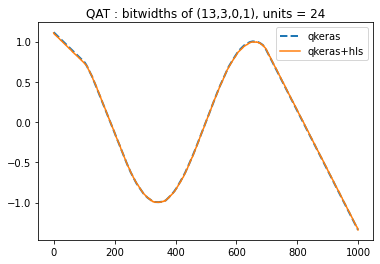

QAT : bitwidths of (13,3,0,1), units = 26
Interpreting Sequential
Topology:
Layer name: q_dense_357_input, layer type: Input
Layer name: q_dense_357, layer type: QDense
Layer name: q_dense_358, layer type: QDense
Layer name: q_dense_359, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_357_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_357': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}, 'q_dense_358': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}, 'q_dense_359': {'Precision': {'weight': 'ap_fixed<13,4>', 'bias': 'ap_fixed<13,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_357_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_357, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 26]
Layer name: q_dense_358, laye

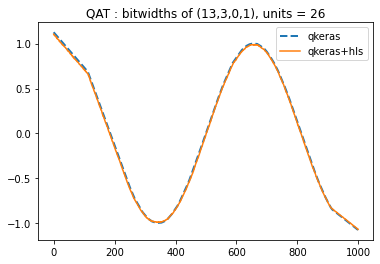

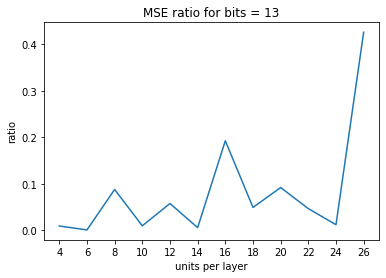

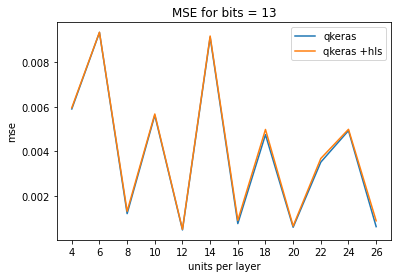

QAT : bitwidths of (14,3,0,1), units = 4
Interpreting Sequential
Topology:
Layer name: q_dense_360_input, layer type: Input
Layer name: q_dense_360, layer type: QDense
Layer name: q_dense_361, layer type: QDense
Layer name: q_dense_362, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_360_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_360': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}, 'q_dense_361': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}, 'q_dense_362': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_360_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_360, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 4]
Layer name: q_dense_361, layer 

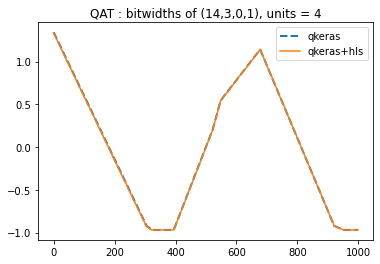

QAT : bitwidths of (14,3,0,1), units = 6
Interpreting Sequential
Topology:
Layer name: q_dense_363_input, layer type: Input
Layer name: q_dense_363, layer type: QDense
Layer name: q_dense_364, layer type: QDense
Layer name: q_dense_365, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_363_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_363': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}, 'q_dense_364': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}, 'q_dense_365': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_363_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_363, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 6]
Layer name: q_dense_364, layer 

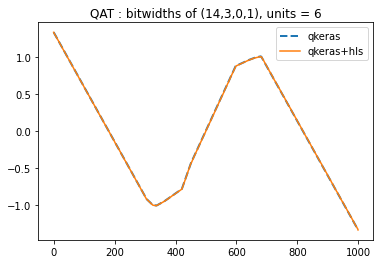

QAT : bitwidths of (14,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: q_dense_366_input, layer type: Input
Layer name: q_dense_366, layer type: QDense
Layer name: q_dense_367, layer type: QDense
Layer name: q_dense_368, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_366_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_366': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}, 'q_dense_367': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}, 'q_dense_368': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_366_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_366, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 8]
Layer name: q_dense_367, layer 

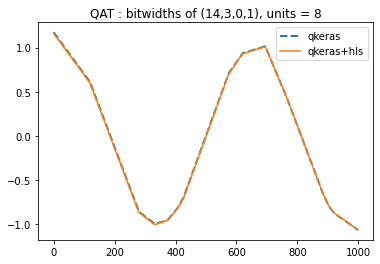

QAT : bitwidths of (14,3,0,1), units = 10
Interpreting Sequential
Topology:
Layer name: q_dense_369_input, layer type: Input
Layer name: q_dense_369, layer type: QDense
Layer name: q_dense_370, layer type: QDense
Layer name: q_dense_371, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_369_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_369': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}, 'q_dense_370': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}, 'q_dense_371': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_369_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_369, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_370, laye

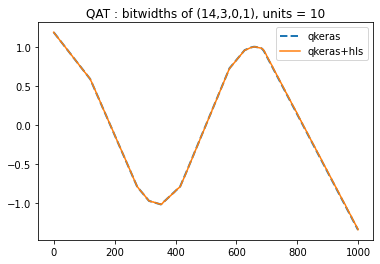

QAT : bitwidths of (14,3,0,1), units = 12
Interpreting Sequential
Topology:
Layer name: q_dense_372_input, layer type: Input
Layer name: q_dense_372, layer type: QDense
Layer name: q_dense_373, layer type: QDense
Layer name: q_dense_374, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_372_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_372': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}, 'q_dense_373': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}, 'q_dense_374': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_372_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_372, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 12]
Layer name: q_dense_373, laye

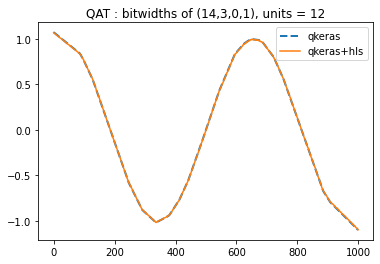

QAT : bitwidths of (14,3,0,1), units = 14
Interpreting Sequential
Topology:
Layer name: q_dense_375_input, layer type: Input
Layer name: q_dense_375, layer type: QDense
Layer name: q_dense_376, layer type: QDense
Layer name: q_dense_377, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_375_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_375': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}, 'q_dense_376': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}, 'q_dense_377': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_375_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_375, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 14]
Layer name: q_dense_376, laye

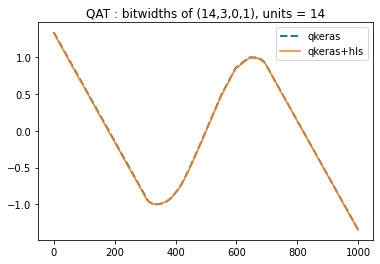

QAT : bitwidths of (14,3,0,1), units = 16
Interpreting Sequential
Topology:
Layer name: q_dense_378_input, layer type: Input
Layer name: q_dense_378, layer type: QDense
Layer name: q_dense_379, layer type: QDense
Layer name: q_dense_380, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_378_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_378': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}, 'q_dense_379': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}, 'q_dense_380': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_378_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_378, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 16]
Layer name: q_dense_379, laye

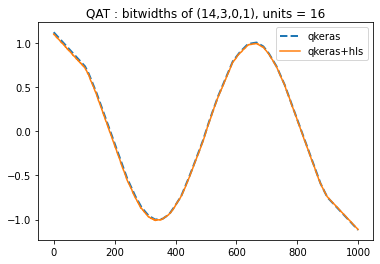

QAT : bitwidths of (14,3,0,1), units = 18
Interpreting Sequential
Topology:
Layer name: q_dense_381_input, layer type: Input
Layer name: q_dense_381, layer type: QDense
Layer name: q_dense_382, layer type: QDense
Layer name: q_dense_383, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_381_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_381': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}, 'q_dense_382': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}, 'q_dense_383': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_381_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_381, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 18]
Layer name: q_dense_382, laye

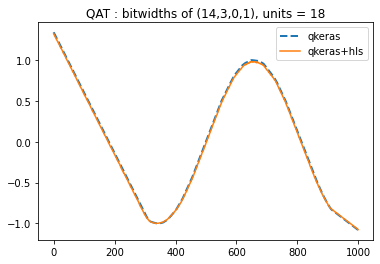

QAT : bitwidths of (14,3,0,1), units = 20
Interpreting Sequential
Topology:
Layer name: q_dense_384_input, layer type: Input
Layer name: q_dense_384, layer type: QDense
Layer name: q_dense_385, layer type: QDense
Layer name: q_dense_386, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_384_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_384': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}, 'q_dense_385': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}, 'q_dense_386': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_384_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_384, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 20]
Layer name: q_dense_385, laye

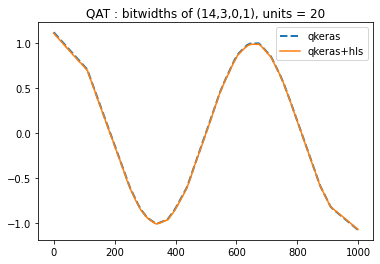

QAT : bitwidths of (14,3,0,1), units = 22
Interpreting Sequential
Topology:
Layer name: q_dense_387_input, layer type: Input
Layer name: q_dense_387, layer type: QDense
Layer name: q_dense_388, layer type: QDense
Layer name: q_dense_389, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_387_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_387': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}, 'q_dense_388': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}, 'q_dense_389': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_387_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_387, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 22]
Layer name: q_dense_388, laye

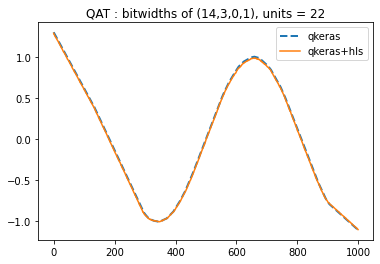

QAT : bitwidths of (14,3,0,1), units = 24
Interpreting Sequential
Topology:
Layer name: q_dense_390_input, layer type: Input
Layer name: q_dense_390, layer type: QDense
Layer name: q_dense_391, layer type: QDense
Layer name: q_dense_392, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_390_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_390': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}, 'q_dense_391': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}, 'q_dense_392': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_390_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_390, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 24]
Layer name: q_dense_391, laye

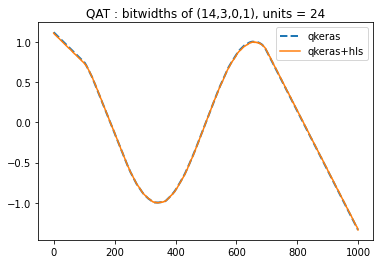

QAT : bitwidths of (14,3,0,1), units = 26
Interpreting Sequential
Topology:
Layer name: q_dense_393_input, layer type: Input
Layer name: q_dense_393, layer type: QDense
Layer name: q_dense_394, layer type: QDense
Layer name: q_dense_395, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_393_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_393': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}, 'q_dense_394': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}, 'q_dense_395': {'Precision': {'weight': 'ap_fixed<14,4>', 'bias': 'ap_fixed<14,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_393_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_393, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 26]
Layer name: q_dense_394, laye

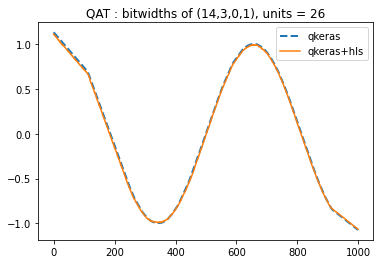

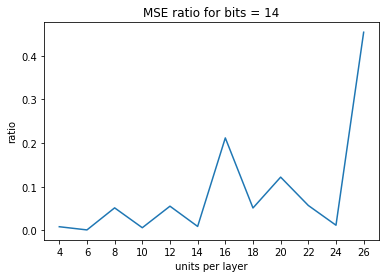

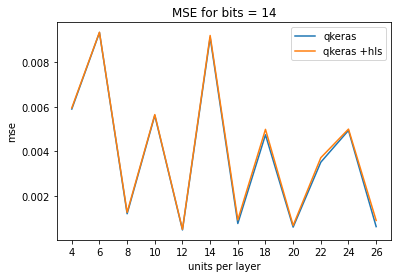

QAT : bitwidths of (15,3,0,1), units = 4
Interpreting Sequential
Topology:
Layer name: q_dense_396_input, layer type: Input
Layer name: q_dense_396, layer type: QDense
Layer name: q_dense_397, layer type: QDense
Layer name: q_dense_398, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_396_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_396': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_397': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_398': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_396_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_396, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 4]
Layer name: q_dense_397, layer 

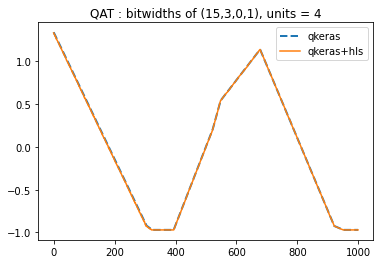

QAT : bitwidths of (15,3,0,1), units = 6
Interpreting Sequential
Topology:
Layer name: q_dense_399_input, layer type: Input
Layer name: q_dense_399, layer type: QDense
Layer name: q_dense_400, layer type: QDense
Layer name: q_dense_401, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_399_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_399': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_400': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_401': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_399_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_399, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 6]
Layer name: q_dense_400, layer 

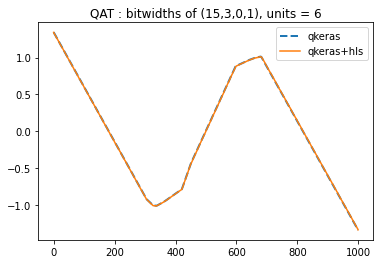

QAT : bitwidths of (15,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: q_dense_402_input, layer type: Input
Layer name: q_dense_402, layer type: QDense
Layer name: q_dense_403, layer type: QDense
Layer name: q_dense_404, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_402_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_402': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_403': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_404': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_402_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_402, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 8]
Layer name: q_dense_403, layer 

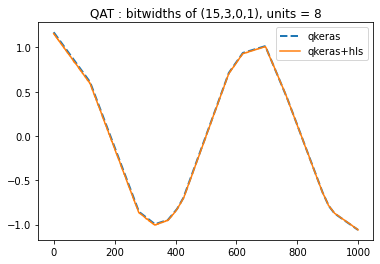

QAT : bitwidths of (15,3,0,1), units = 10
Interpreting Sequential
Topology:
Layer name: q_dense_405_input, layer type: Input
Layer name: q_dense_405, layer type: QDense
Layer name: q_dense_406, layer type: QDense
Layer name: q_dense_407, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_405_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_405': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_406': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_407': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_405_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_405, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_406, laye

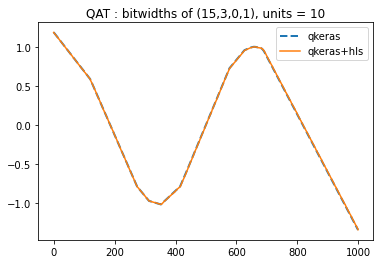

QAT : bitwidths of (15,3,0,1), units = 12
Interpreting Sequential
Topology:
Layer name: q_dense_408_input, layer type: Input
Layer name: q_dense_408, layer type: QDense
Layer name: q_dense_409, layer type: QDense
Layer name: q_dense_410, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_408_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_408': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_409': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_410': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_408_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_408, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 12]
Layer name: q_dense_409, laye

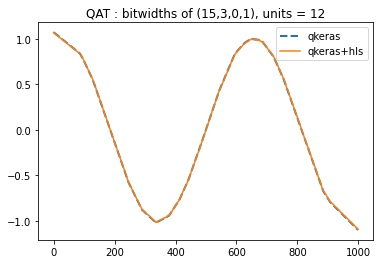

QAT : bitwidths of (15,3,0,1), units = 14
Interpreting Sequential
Topology:
Layer name: q_dense_411_input, layer type: Input
Layer name: q_dense_411, layer type: QDense
Layer name: q_dense_412, layer type: QDense
Layer name: q_dense_413, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_411_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_411': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_412': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_413': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_411_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_411, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 14]
Layer name: q_dense_412, laye

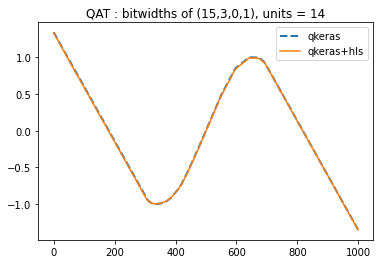

QAT : bitwidths of (15,3,0,1), units = 16
Interpreting Sequential
Topology:
Layer name: q_dense_414_input, layer type: Input
Layer name: q_dense_414, layer type: QDense
Layer name: q_dense_415, layer type: QDense
Layer name: q_dense_416, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_414_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_414': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_415': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_416': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_414_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_414, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 16]
Layer name: q_dense_415, laye

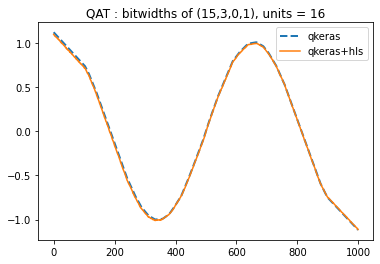

QAT : bitwidths of (15,3,0,1), units = 18
Interpreting Sequential
Topology:
Layer name: q_dense_417_input, layer type: Input
Layer name: q_dense_417, layer type: QDense
Layer name: q_dense_418, layer type: QDense
Layer name: q_dense_419, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_417_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_417': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_418': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_419': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_417_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_417, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 18]
Layer name: q_dense_418, laye

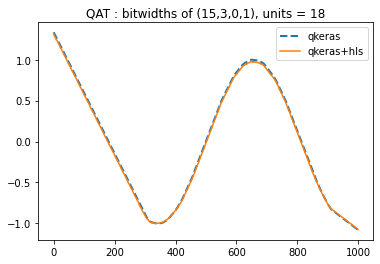

QAT : bitwidths of (15,3,0,1), units = 20
Interpreting Sequential
Topology:
Layer name: q_dense_420_input, layer type: Input
Layer name: q_dense_420, layer type: QDense
Layer name: q_dense_421, layer type: QDense
Layer name: q_dense_422, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_420_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_420': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_421': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_422': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_420_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_420, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 20]
Layer name: q_dense_421, laye

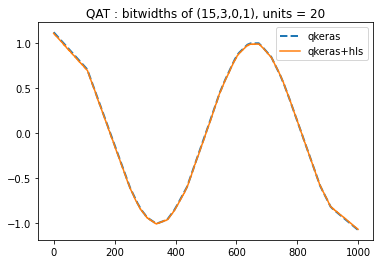

QAT : bitwidths of (15,3,0,1), units = 22
Interpreting Sequential
Topology:
Layer name: q_dense_423_input, layer type: Input
Layer name: q_dense_423, layer type: QDense
Layer name: q_dense_424, layer type: QDense
Layer name: q_dense_425, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_423_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_423': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_424': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_425': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_423_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_423, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 22]
Layer name: q_dense_424, laye

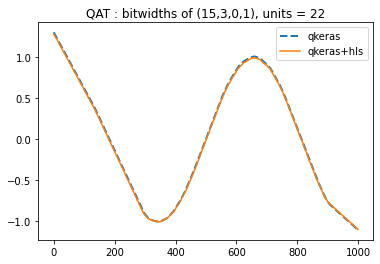

QAT : bitwidths of (15,3,0,1), units = 24
Interpreting Sequential
Topology:
Layer name: q_dense_426_input, layer type: Input
Layer name: q_dense_426, layer type: QDense
Layer name: q_dense_427, layer type: QDense
Layer name: q_dense_428, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_426_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_426': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_427': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_428': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_426_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_426, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 24]
Layer name: q_dense_427, laye

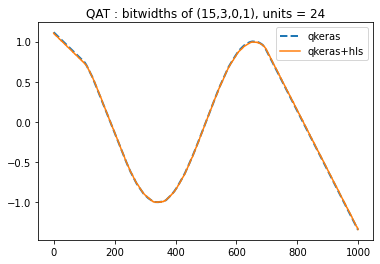

QAT : bitwidths of (15,3,0,1), units = 26
Interpreting Sequential
Topology:
Layer name: q_dense_429_input, layer type: Input
Layer name: q_dense_429, layer type: QDense
Layer name: q_dense_430, layer type: QDense
Layer name: q_dense_431, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_429_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_429': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_430': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_431': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_429_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_429, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 26]
Layer name: q_dense_430, laye

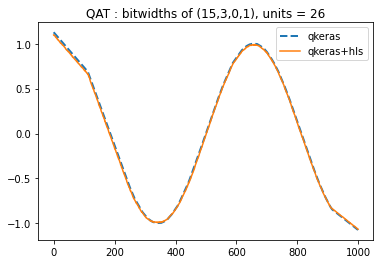

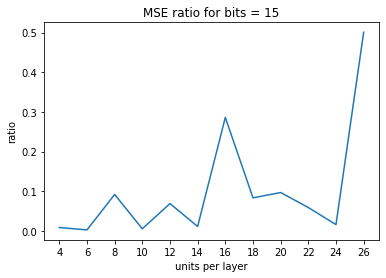

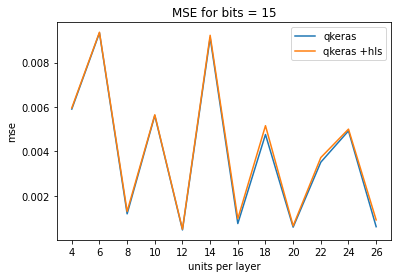

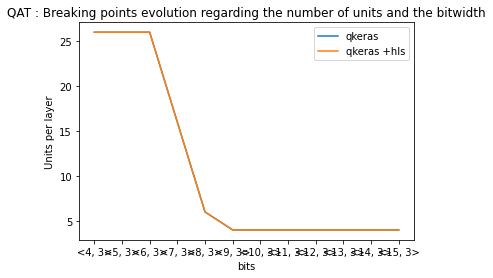

In [25]:
####### quantized model 

breaking_ratio_points = [] 
q_bps = []
qhls_bps = [] 
bits_nbr = []
qat_results = []


for i in range (bits_range):
    qkeras_bp = units(0)
    qhls_bp = units(0)
    breaking_ratio_point = units(0)
    units_nbr = []
    mse_ratio = []
    qloss = []
    qhloss = []
    for j in range (units_range):

        print(f'QAT : bitwidths of ({bit_lenghts(i)},{integer},0,1), units = {units(j)}')
        conf = hls4ml.utils.config_from_keras_model(qkeras.utils.load_qmodel(qmodels_path(i,j)), granularity='name')

        print(conf)

        hls_qmodel = hls4ml.converters.convert_from_keras_model(qkeras.utils.load_qmodel(qmodels_path(i,j)),
                                                            hls_config=conf,
                                                            output_dir='models/hls_models',
                                                            part='1SG280HU2F50E2VG',
                                                            backend='Quartus')
                                    
        hls_qmodel.compile()

        y_qkeras = existnorm(qpredicts_path(i,j),qkeras.utils.load_qmodel(qmodels_path(i,j) ))
        y_qhls = exist(qpredicts_path_QAT(i,j), hls_qmodel)
        
        qat_results.append(y_qhls)
        
        mse_qkeras = mse(y_test, y_qkeras)
        mse_qhls = mse(y_test, y_qhls)
        qhloss.append(mse_qhls)
        qloss.append(mse_qkeras)

        units_nbr.append(units(j))
        
        #Implementation of the breaking point
        ratio =(abs(mse(y_test, y_qkeras) - mse(y_test, y_qhls))/mse(y_test, y_qkeras))
        print(f'ratio of bits = {bit_lenghts(i)} and units =  {units(j)}',ratio)
        mse_ratio.append(ratio)
        if  (ratio>0.02):
            print('new bp detected')
            breaking_ratio_point = units(j)
        
        if (mse_qkeras > 0.01):
            print('new qbp detected', units(j))
            qkeras_bp = units(j)
            
        if (mse_qhls > 0.01):
            print('new qhls bp detected', units(j))

            qhls_bp = units(j)

        #Plotting of the predictions
        plt.figure()
        plt.plot(y_qkeras, '--', linewidth=2)
        plt.plot(y_qhls)    
        plt.legend(['qkeras', 'qkeras+hls'])
        plt.title(f'QAT : bitwidths of ({bit_lenghts(i)},{integer},0,1), units = {units(j)}')
        plt.show()
       

    #plotting of the evolution of the breaking points through the number of units with a given a bit lenghts
    bits_nbr.append(bit_lenghts(i))
    breaking_ratio_points.append(breaking_ratio_point)
    plt.figure()
    plt.plot(mse_ratio)
    plt.xticks(np.arange(len(units_nbr)), [f"{units}" for units in units_nbr])
    plt.xlabel('units per layer')
    plt.ylabel('ratio')
    plt.title(f'MSE ratio for bits = {bit_lenghts(i)}')
    plt.show()

    #plotting the mse for a given bitlenghts
    q_bps.append(qkeras_bp)
    qhls_bps.append(qhls_bp)
    plt.figure()
    plt.plot(qloss)
    plt.plot(qhloss)
    plt.xticks(np.arange(len(units_nbr)), [f"{units}" for units in units_nbr])
    plt.legend(['qkeras','qkeras +hls'])
    plt.xlabel('units per layer')
    plt.ylabel('mse')
    plt.title(f'MSE for bits = {bit_lenghts(i)}')
    plt.show()


plt.figure()
plt.plot(q_bps)
plt.plot(qhls_bps)
plt.legend(['qkeras','qkeras +hls'])
plt.xlabel('bits')
plt.ylabel('Units per layer')
plt.xticks(np.arange(len(bits_nbr)), [f"<{bits}, {integer}>" for bits in bits_nbr])
plt.title('QAT : Breaking points evolution regarding the number of units and the bitwidth')

plt.show()

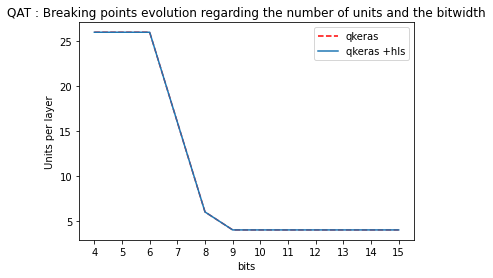

In [26]:
plt.figure()
plt.plot(q_bps,'--r')
plt.plot(qhls_bps)
plt.legend(['qkeras','qkeras +hls'])
plt.xlabel('bits')
plt.ylabel('Units per layer')
plt.xticks(np.arange(len(bits_nbr)), [f"{bits}" for bits in bits_nbr])
plt.title('QAT : Breaking points evolution regarding the number of units and the bitwidth')

plt.show()

## Results

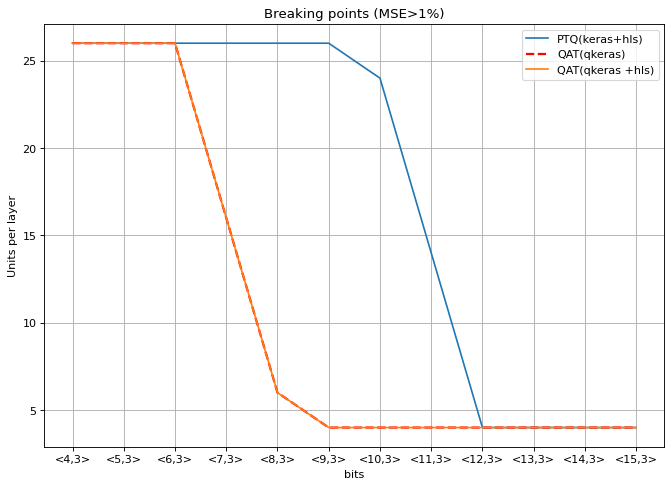

In [28]:
plt.figure(figsize=(10, 7), dpi=80)

plt.plot(hls_bps)

plt.plot(q_bps,'--r', linewidth = 2)
plt.plot(qhls_bps)
plt.grid()

plt.legend(['PTQ(keras+hls)','QAT(qkeras)','QAT(qkeras +hls)'])
plt.xlabel('bits')
plt.ylabel('Units per layer')
plt.xticks(np.arange(len(bits_nbr)), [f"<{bits},{integer}>" for bits in bits_nbr])
plt.title('Breaking points (MSE>1%)')

plt.show()